In [1]:
pip install scikit-learn


In [2]:
pip install xgboost

In [3]:
# Matrix Manipulation Packages/Libraries
import pandas as pd
import numpy as np

# Statistical Analysis & Machine Learning Packages/Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import pearsonr
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold , RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn.neighbors
from sklearn.feature_selection import mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, randint
import sklearn.ensemble
from sklearn.metrics import confusion_matrix

# Data Visualization Packages/Libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import plot_tree

import warnings
from sklearn.exceptions import ConvergenceWarning

#Pre-Processing the dataset

In [4]:
# Load the dataset and pre-processing the dataset
def data_preprocessing (cases_file, controls_file, clinical_file):
    cases = pd.read_csv(cases_file);
    controls = pd.read_csv(controls_file);
    cases.fillna('Other', inplace = True);
    controls.fillna('Other', inplace = True);
    df = pd.concat([cases, controls])
    df = df[['SID','Gender','Race','Age','Type','ID','gene_id','length', 'effective_length','TPM', 'FPKM']];
    df = preprocessing_helper(df, clinical_file);
    df = df.fillna(0)
    return df


def preprocessing_helper (dataframe, clinical_file):
    df = pd.pivot_table(dataframe, index = "SID", columns = 'gene_id', values = 'TPM').reset_index()
    df = df.rename(columns = {'SID': 'ID'})
    clinical_data = pd.read_csv(clinical_file)
    clinical_data = clinical_data.drop('Unnamed: 0', axis = 1)
    df = df.merge(clinical_data, how = 'left')
    unprocessed_df = df
    df.loc[df['Race'] == 'White ', 'Race'] = 'White'
    df.loc[df['Race'] == 'Other', 'Race'] = 6
    df.loc[df['Race'] == 'White', 'Race'] = 1
    df.loc[df['Race'] == 'Black', 'Race'] = 2
    df.loc[df['Race'] == 'Asian', 'Race'] = 19
    df.loc[df['Race'] == 'Decline to Answer', 'Race'] = 7
    df.loc[df['Gender'] == 'Other', 'Gender'] = 999
    df.loc[df['Gender'] == 'Female', 'Gender'] = 0
    df.loc[df['Gender'] == 'Male', 'Gender'] = 1
    df.drop(df.index[df['Age'] == 'Other'],inplace = True)
    df.loc[df['Type'] == 'Control', 'Type'] = 1
    df.loc[df['Type'] == 'Case', 'Type'] = 0
    percentage_cut = 20.0
    minimum_count =  int(((100 - percentage_cut) / 100) * df.shape[0] + 1)
    df = df.dropna(axis = 1, thresh = minimum_count)
    print("Original Features: ", len(unprocessed_df.columns))
    print("Preprocessed Features: ", len(df.columns))
    return df


import os

os.chdir("/content/drive/MyDrive/SRH_Thesis/Dataset/")

df = data_preprocessing('/content/drive/MyDrive/SRH_Thesis/Dataset/GeneAI_TPM_10_CVD_Cohort_C1_09222022.csv',
                        '/content/drive/MyDrive/SRH_Thesis/Dataset/GeneAI_TPM_10_Control_Cohort_C1_10032022.csv',
                        '/content/drive/MyDrive/SRH_Thesis/Dataset/gene_cohort_clinical_data.csv')

#Display of the results of dataset creation
from pprint import pprint
pprint(df)

Original Features:  9012
Preprocessed Features:  753
      ID  ENSG00000000938  ENSG00000002586  ENSG00000004059  ENSG00000005022  \
0    648           255.41            51.52            75.05            50.43   
1    649           285.68            75.96            96.70            74.86   
2    650           266.67            52.12            73.38            50.00   
3    651           373.89            65.84           113.04            59.61   
4    652           249.39            55.06            76.96            53.61   
..   ...              ...              ...              ...              ...   
67  1114            35.05            22.07            34.82            21.81   
68  1115            11.39            11.38            19.11            24.73   
69  1116             0.00             0.00            11.58             0.00   
70  1117             0.00             0.00            12.90            15.59   
71  1118             0.00             0.00             0.00        

<ipython-input-4-56c8ba2eb032>:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


#Exploratory Analysis

<ipython-input-5-402ae5592264>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Male' 'Male' 'Male' 'Female' 'Male' 'Female' 'Male' 'Female' 'Female'
 'Female' 'Female' 'Male' 'Male' 'Male' 'Male' 'Male' 'Female' 'Female'
 'Male' 'Male' 'Male' 'Female' 'Male' 'Female' 'Female' 'Female' 'Female'
 'Female' 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Female' 'Male'
 'Female' 'Male' 'Male' 'Female' 'Female' 'Male' 'Male' 'Male' 'Male'
 'Female' 'Male' 'Male' 'Male' 'Female' 'Male' 'Male' 'Male' 'Male' 'Male'
 'Male' 'Male' 'Female' 'Male' 'Male' 'Female' 'Male' 'Male' 'Female'
 'Male' 'Male' 'Female' 'Male' 'Female' 'Male' 'Male']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  working_dataset.loc[:, 'Gender'] = working_dataset['Gender'].replace({1: 'Male', 0: 'Female'})


<Axes: xlabel='Age', ylabel='Frequency'>

<Figure size 640x480 with 0 Axes>

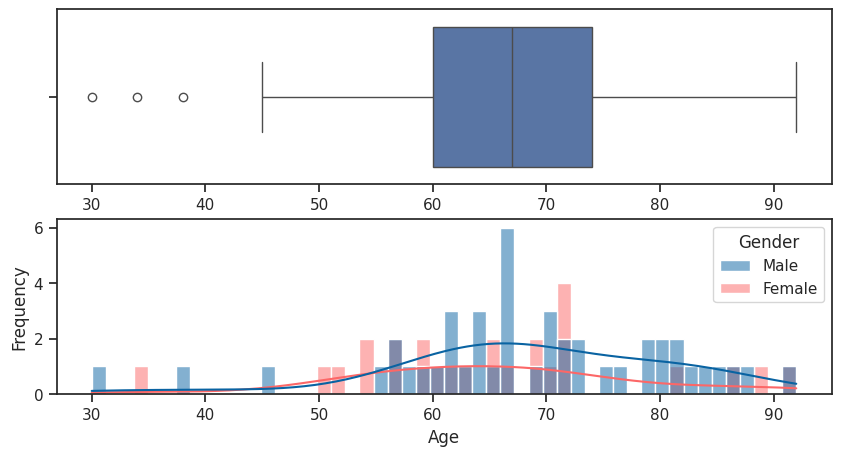

In [5]:
working_dataset = df.loc[df['Age'] != 0]
working_dataset.loc[:, 'Gender'] = working_dataset['Gender'].replace({1: 'Male', 0: 'Female'})
plt.figure()
sns.set(rc={"figure.figsize":(10, 5)})
sns.set_style("whitegrid")
sns.set_style("ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=False)
plt.gca().set(xlabel= "Age" ,ylabel='Frequency')
sns.boxplot(working_dataset, x= "Age", ax= ax_box , linewidth= 1.0)
colors = {'Male': '#0963A2', 'Female': '#FC6767'}
sns.histplot(working_dataset, x='Age', hue='Gender', bins=50, kde=True, palette=colors, ax=ax_hist)

# Feature Selection


In [6]:

# Feature Selection
random_state = 42
test_size = 0.3

kfold = KFold(n_splits = 5, shuffle = True, random_state = random_state)
warnings.filterwarnings("ignore", category = ConvergenceWarning)


y = df['Type']
x = df.drop(['Type', 'ID'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)

x_transformed = np.log1p(x_train)

# Recursive Feature Elimination
rfe = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = 1)
rfe.fit(x_train, y_train)

rfe_scores = pd.DataFrame(rfe.ranking_)
rfe_features = pd.DataFrame(x_train.columns)

rfe_df = pd.concat([rfe_features, rfe_scores], axis = 1)
rfe_df.columns = ['Ensembl ID', 'RFE Score']
rfe_df_sorted = rfe_df.sort_values(by=['RFE Score'])
rfe_df_significant = rfe_df_sorted[rfe_df_sorted['RFE Score'] <= int((df.shape[1] - 2) * .10)]

rfe_df_significant


Ensembl ID  RFE Score
739  ENSG00000256618          1
750              Age          2
749             Race          3
748           Gender          4
747  ENSG00000269858          5
..               ...        ...
724  ENSG00000242574         71
44   ENSG00000082146         72
723  ENSG00000241837         73
45   ENSG00000083845         74
722  ENSG00000241553         75

[75 rows x 2 columns]

In [7]:
# Pearson Correlation
person_correlations = [pearsonr(x[column], y) for column in x.columns]

pearson_df = pd.DataFrame(person_correlations, columns=['Correlation Coefficient', 'p-value'],
                          index = x.columns).reset_index().rename(columns={'index': 'Ensembl ID'})

pearson_df['Absolute Correlation Coefficient'] = np.abs(pearson_df['Correlation Coefficient'])

pearson_df_sorted = pearson_df.sort_values(by='Absolute Correlation Coefficient',
                                    ascending = False).drop('Absolute Correlation Coefficient', axis = 1)

pearson_df_significant = pearson_df_sorted[pearson_df_sorted['p-value'] < 0.05]

pearson_df_significant

Ensembl ID  Correlation Coefficient       p-value
343  ENSG00000143384                 0.728992  3.864547e-13
295  ENSG00000135821                 0.706694  4.021985e-12
330  ENSG00000142347                 0.700407  7.488174e-12
139  ENSG00000108654                 0.694624  1.308059e-11
94   ENSG00000102879                 0.693298  1.483833e-11
..               ...                      ...           ...
717  ENSG00000240065                 0.233979  4.790793e-02
82   ENSG00000100568                 0.233065  4.881140e-02
746  ENSG00000268903                 0.232284  4.959442e-02
494  ENSG00000170275                 0.232251  4.962756e-02
305  ENSG00000136908                 0.232031  4.985032e-02

[355 rows x 3 columns]

In [8]:
# Chi-Squared Test
chisq_features = SelectKBest(score_func = chi2, k = 10)
chisq_fit = chisq_features.fit(x_train, y_train)

chisq_scores = pd.DataFrame(chisq_fit.scores_)
chisq_pvalues = pd.DataFrame(chisq_fit.pvalues_)
chisq_labels = pd.DataFrame(x_train.columns)

chisq_df = pd.concat([chisq_labels, chisq_scores, chisq_pvalues], axis = 1)
chisq_df.columns = ['Ensembl ID', 'Chi-Square Statistic', 'p-value']
chisq_df_sorted = chisq_df.sort_values(by=['Chi-Square Statistic'], ascending = False)
chisq_df_significant = chisq_df_sorted[chisq_df_sorted['p-value'] < 0.05]

chisq_df_significant

Ensembl ID  Chi-Square Statistic   p-value
588  ENSG00000188536         272938.184348  0.000000
661  ENSG00000206172         249778.751157  0.000000
729  ENSG00000244734         123869.836746  0.000000
666  ENSG00000211592          34627.685480  0.000000
39   ENSG00000075624          23617.826150  0.000000
..               ...                   ...       ...
305  ENSG00000136908              4.168734  0.041177
586  ENSG00000188243              4.105952  0.042733
573  ENSG00000185262              3.993936  0.045664
397  ENSG00000158578              3.886057  0.048689
504  ENSG00000171700              3.849383  0.049764

[681 rows x 3 columns]

In [9]:
# Analysis of Variance
anova_features = SelectKBest(score_func = f_classif, k = 10).fit(x_train, y_train)

anova_scores = pd.DataFrame(anova_features.scores_, columns=['F-Statistic'])
anova_pvalues = pd.DataFrame(anova_features.pvalues_, columns=['p-value'])
anova_labels = pd.DataFrame(x_train.columns, columns=['Ensembl ID'])

anova_df = pd.concat([anova_labels, anova_scores, anova_pvalues], axis = 1)
anova_df_sorted = anova_df.sort_values('F-Statistic', ascending = False)
anova_df_significant = anova_df_sorted[anova_df_sorted['p-value'] < 0.05]

anova_df_significant

Ensembl ID  F-Statistic       p-value
343  ENSG00000143384    65.331203  1.651590e-10
94   ENSG00000102879    60.546244  4.722949e-10
69   ENSG00000099622    58.687519  7.195466e-10
488  ENSG00000169564    55.124980  1.647595e-09
330  ENSG00000142347    54.947093  1.718501e-09
..               ...          ...           ...
209  ENSG00000122694     4.103353  4.837701e-02
172  ENSG00000113811     4.061078  4.950114e-02
120  ENSG00000105583     4.060570  4.951483e-02
472  ENSG00000167705     4.052280  4.973865e-02
279  ENSG00000131981     4.047148  4.987778e-02

[318 rows x 3 columns]

In [10]:
# Complete Merged Table
merged_df = (anova_df_sorted.merge(chisq_df_sorted, on='Ensembl ID', how='outer')
                             .merge(pearson_df_sorted, on='Ensembl ID', how='outer')
                             .merge(rfe_df_sorted, on='Ensembl ID', how='outer'))

merged_df.columns = ['Ensembl ID',
                     'F-Statistic', 'p-value (ANOVA)',
                     'Chi-Square Statistic', 'p-value (Chi-Squared Test)',
                     'Correlation Coefficient', 'p-value (Pearson Correlation)',
                     'RFE Score']

merged_df.to_csv('/content/drive/MyDrive/SRH_Thesis/Results/Biomarker-Selection.csv', index = None)

In [11]:
# Supported Biomarkers

biomarkers_df = anova_df_sorted.merge(chisq_df_sorted, on='Ensembl ID').merge(pearson_df_sorted, on='Ensembl ID')

biomarkers_df.columns = ['Ensembl ID',
                         'F-Statistic', 'p-value (ANOVA)',
                         'Chi-Square Statistic', 'p-value (Chi-Squared Test)',
                         'Correlation Coefficient', 'p-value (Pearson Correlation)']

statistical_biomarkers_df = biomarkers_df[(biomarkers_df['p-value (ANOVA)'] < 0.05)
                                          & (biomarkers_df['p-value (Chi-Squared Test)'] < 0.05)
                                          & (biomarkers_df['p-value (Pearson Correlation)'] < 0.05)]

rfe_quantile = int((df.shape[1] - 2) * .10)

rfe_biomarkers_df = statistical_biomarkers_df.merge(rfe_df_sorted, on='Ensembl ID')
significant_biomarkers_df = rfe_biomarkers_df[rfe_biomarkers_df['RFE Score'] <= rfe_quantile]

significant_biomarkers_list = significant_biomarkers_df['Ensembl ID'].values

significant_biomarkers_df

Ensembl ID  F-Statistic  p-value (ANOVA)  Chi-Square Statistic  \
9    ENSG00000013364    45.766332     1.685695e-08           1478.596447   
19   ENSG00000010404    36.052244     2.469256e-07            364.453050   
23   ENSG00000076944    35.116940     3.252401e-07            993.923187   
27   ENSG00000000938    33.328458     5.558972e-07           3035.833373   
29   ENSG00000077454    33.018973     6.107002e-07            855.993460   
35   ENSG00000018280    31.230362     1.059544e-06           2545.003799   
47   ENSG00000064666    28.525362     2.501576e-06           2196.072199   
56   ENSG00000075624    26.152966     5.461732e-06          23617.826150   
61   ENSG00000067560    25.517045     6.764512e-06           1846.793395   
64   ENSG00000062716    25.159990     7.634609e-06           1531.165598   
69   ENSG00000070756    23.836275     1.202516e-05           3259.120339   
70   ENSG00000075415    23.146951     1.529077e-05            520.322783   
73   ENSG00000030582    22.857802     1.692502e-05           2034.146534   
75   ENSG00000074800    22.676383     1.804267e-05           1534.972131   
76   ENSG00000076662    22.527005     1.902072e-05           1213.352788   
87   ENSG00000019582    20.573780     3.837894e-05          19834.252733   
104  ENSG00000266422    18.461681     8.413943e-05           6099.039146   
110  ENSG00000242574    17.331401     1.295944e-04           1182.198479   
126  ENSG00000256618    15.446228     2.716971e-04            425.057043   
134  ENSG00000265150    14.623182     3.784834e-04           5570.193207   
137  ENSG00000067182    14.312210     4.295755e-04           1164.492117   
139  ENSG00000026297    14.042408     4.797611e-04           1050.494529   
141  ENSG00000026508    13.832965     5.229415e-04            431.188959   
153  ENSG00000241553    12.825211     7.957514e-04            967.241151   
157  ENSG00000023902    12.586940     8.799195e-04            293.835527   
160  ENSG00000256514    12.516301     9.066306e-04             97.158556   
189  ENSG00000247596    10.131465     2.558096e-03            169.360342   
203  ENSG00000269858     9.331682     3.670018e-03            199.903685   
223  ENSG00000064490     8.518694     5.336756e-03             45.891543   
236  ENSG00000026025     7.690281     7.882265e-03            992.817668   
247  ENSG00000005022     7.059406     1.067460e-02             95.509308   
249  ENSG00000082146     7.024577     1.085663e-02             79.066924   
259  ENSG00000245910     6.440925     1.445292e-02            146.302324   
266  ENSG00000042753     5.987261     1.812143e-02             45.313322   
283  ENSG00000254999     5.208093     2.695542e-02            105.501496   
285  ENSG00000002586     5.098836     2.852582e-02            141.921513   
291  ENSG00000066336     4.844561     3.257566e-02            643.414965   
300  ENSG00000065978     4.538881     3.828489e-02            174.425322   
301  ENSG00000260592     4.491244     3.926828e-02             45.016687   
303  ENSG00000060138     4.407322     4.106807e-02            145.523815   
307  ENSG00000025708     4.125910     4.778864e-02            217.288791   

     p-value (Chi-Squared Test)  Correlation Coefficient  \
9                  0.000000e+00                 0.670849   
19                 3.019684e-81                 0.612250   
23                3.759673e-218                 0.576389   
27                 0.000000e+00                 0.611739   
29                3.618936e-188                 0.560535   
35                 0.000000e+00                 0.620825   
47                 0.000000e+00                 0.594722   
56                 0.000000e+00                 0.568154   
61                 0.000000e+00                 0.559561   
64                 0.000000e+00                 0.562216   
69                 0.000000e+00                 0.524197   
70                3.600113e-115                 0.505825   
73                 0.000000e+00      

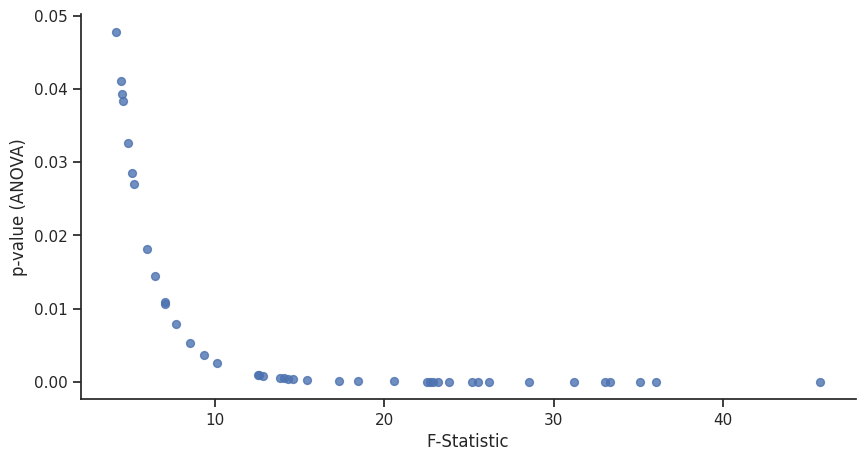

In [31]:
# @title F-Statistic vs p-value (ANOVA)

from matplotlib import pyplot as plt
significant_biomarkers_df.plot(kind='scatter', x='F-Statistic', y='p-value (ANOVA)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

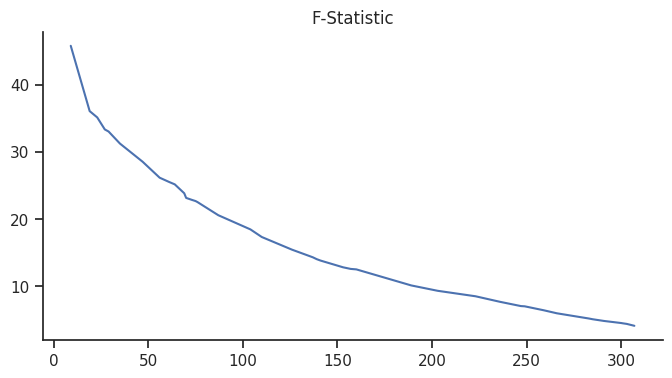

In [30]:
# @title F-Statistic

from matplotlib import pyplot as plt
significant_biomarkers_df['F-Statistic'].plot(kind='line', figsize=(8, 4), title='F-Statistic')
plt.gca().spines[['top', 'right']].set_visible(False)

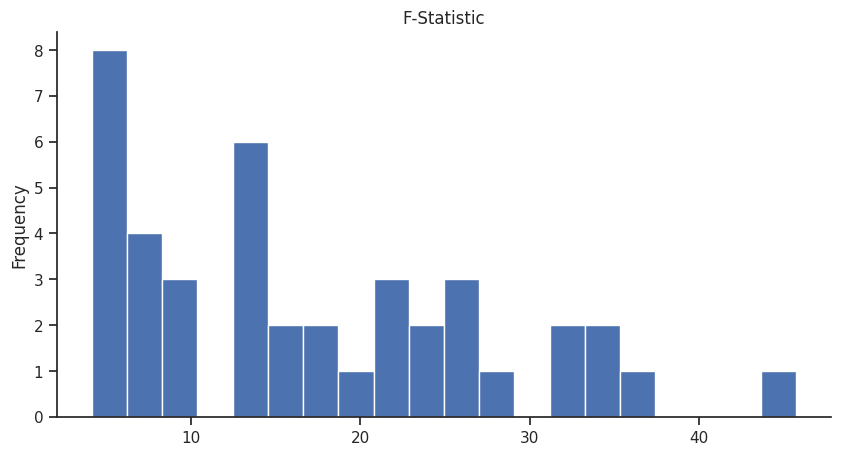

In [29]:
# @title F-Statistic

from matplotlib import pyplot as plt
significant_biomarkers_df['F-Statistic'].plot(kind='hist', bins=20, title='F-Statistic')
plt.gca().spines[['top', 'right',]].set_visible(False)

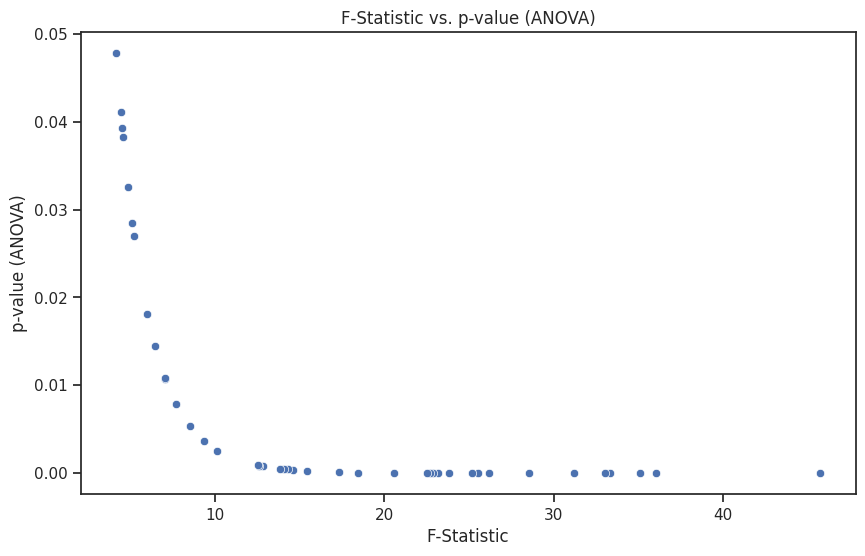

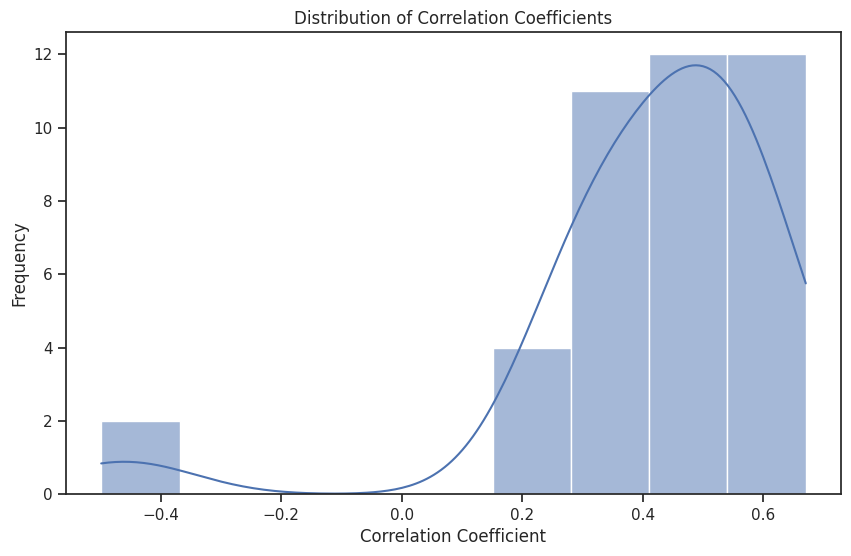

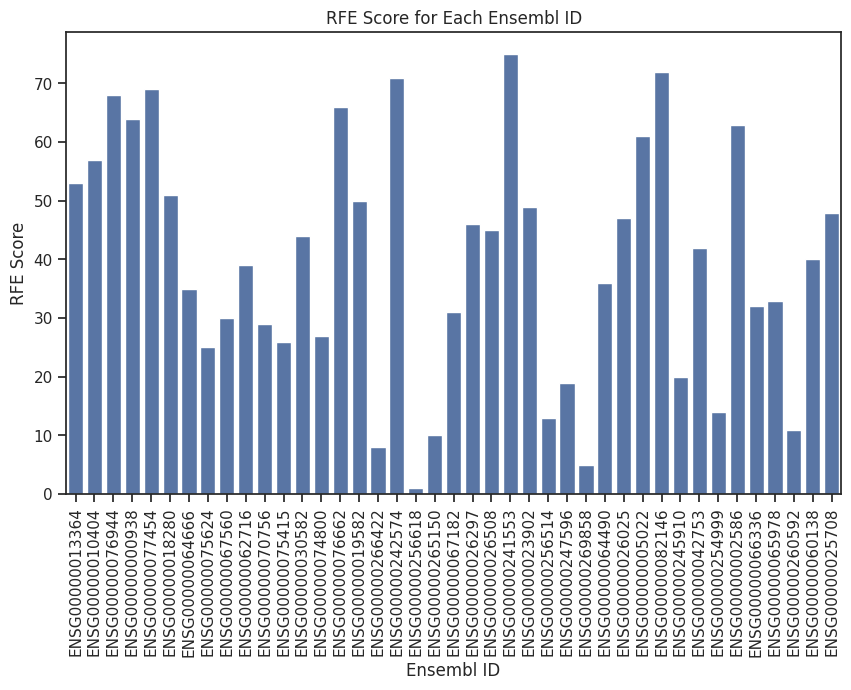

In [12]:
# prompt: Using dataframe significant_biomarkers_df: GRAPH

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatter plot of F-Statistic vs. p-value (ANOVA)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='F-Statistic', y='p-value (ANOVA)', data=significant_biomarkers_df)
plt.xlabel('F-Statistic')
plt.ylabel('p-value (ANOVA)')
plt.title('F-Statistic vs. p-value (ANOVA)')
plt.show()


# Create a histogram of the Correlation Coefficient
plt.figure(figsize=(10, 6))
sns.histplot(x='Correlation Coefficient', data=significant_biomarkers_df, kde=True)
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.title('Distribution of Correlation Coefficients')
plt.show()

# Create a bar plot of the RFE Score for each Ensembl ID
plt.figure(figsize=(10, 6))
sns.barplot(x='Ensembl ID', y='RFE Score', data=significant_biomarkers_df)
plt.xlabel('Ensembl ID')
plt.ylabel('RFE Score')
plt.title('RFE Score for Each Ensembl ID')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

#ML Analysis and Decision Process Methods

In [13]:
y = df['Type']
x = df[significant_biomarkers_list]

random_state = 42
test_size = 0.3

kfold = KFold(n_splits = 5, shuffle = True, random_state = random_state)
warnings.filterwarnings("ignore", category = ConvergenceWarning)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = random_state)

In [15]:
# # Random Forest Classifier (with Hyperparameter Tuning)
# rf = RandomForestClassifier(random_state = 42) # <--- Initialize RF
# rf.fit(x_train, y_train) # <--- Fit RF

# rf_parameter_grid = {
#     'max_features': np.arange(1, x_train.shape[1] + 1),
#     'min_samples_split': np.arange(2, 11),
#     'min_samples_leaf': np.concatenate([np.arange(1, 11), [100, 150]])
# } # <--- Generate Parameter Grid

# rf_best = GridSearchCV(
#     rf, param_grid = rf_parameter_grid, cv = kfold,
#     scoring = 'accuracy', n_jobs = -1, verbose = 0
# ) # <--- Hyperparameter Tuning

# rf_best.fit(x_train, y_train) # <--- Fit GridSearchCV
# rf_best = rf_best.best_estimator_ # <--- Assign Best Estimator

# y_predict = rf_best.predict(x_test) # <--- Predict Target
# rf_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

# y_probs = rf_best.predict_proba(x_test)
# y_probs = y_probs[:, 1] # <--- Predict Positives Classes

# rf_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
# rf_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

# print('Accuracy: ', rf_accuracy)
# print('ROC-AUC: ', rf_roc_auc)
# print('Weighted-Average F1 Score: ', rf_F1)

KeyboardInterrupt: 

In [16]:
# # Random Forest Classifier (with Hyperparameter Tuning)
# rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores for parallel processing

# # Define Parameter Grid (Reduced)
# rf_parameter_grid = {
#     'max_features': np.arange(1, x_train.shape[1] + 1),
#     'min_samples_split': np.arange(2, 11),
#     'min_samples_leaf': np.concatenate([np.arange(1, 11), [100, 150]])
# }  # Same parameter grid

# # Use RandomizedSearchCV for faster hyperparameter tuning
# rf_best = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_parameter_grid,
#     n_iter=20,  # Number of parameter combinations to test (reduced)
#     cv=kfold,
#     scoring='accuracy',
#     n_jobs=-1,
#     verbose=1,
#     random_state=42  # Fix random seed for reproducibility
# )

# # Fit RandomizedSearchCV
# rf_best.fit(x_train, y_train)
# rf_best = rf_best.best_estimator_

# # Predict Target
# y_predict = rf_best.predict(x_test)
# rf_accuracy = accuracy_score(y_test, y_predict)

# # Predict Positive Classes
# y_probs = rf_best.predict_proba(x_test)
# y_probs = y_probs[:, 1]

# # Calculate Metrics
# rf_roc_auc = roc_auc_score(y_test, y_probs)
# rf_F1 = f1_score(y_test, y_predict, average='weighted')

# # Print Results
# print('Accuracy: ', rf_accuracy)
# print('ROC-AUC: ', rf_roc_auc)
# print('Weighted-Average F1 Score: ', rf_F1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy:  0.9545454545454546
ROC-AUC:  0.9583333333333334
Weighted-Average F1 Score:  0.9564213564213563


In [17]:
# Random Forest Classifier (with Hyperparameter Tuning)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)  # Use all CPU cores for parallel processing

# Define Parameter Grid (Reduced)
rf_parameter_grid = {
    'max_features': np.arange(1, x_train.shape[1] + 1),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.concatenate([np.arange(1, 11), [100, 150]])
}  # Same parameter grid

# Use RandomizedSearchCV for faster hyperparameter tuning
rf_best_random = RandomizedSearchCV( # changed variable name from rf_best to rf_best_random to avoid overwriting
    estimator=rf,
    param_distributions=rf_parameter_grid,
    n_iter=20,  # Number of parameter combinations to test (reduced)
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42  # Fix random seed for reproducibility
)

# Fit RandomizedSearchCV
rf_best_random.fit(x_train, y_train)
rf_best_random = rf_best_random.best_estimator_

# Predict Target
y_predict = rf_best_random.predict(x_test) # changed rf_best to rf_best_random
rf_accuracy = accuracy_score(y_test, y_predict)

# Predict Positive Classes
y_probs = rf_best_random.predict_proba(x_test) # changed rf_best to rf_best_random
y_probs = y_probs[:, 1]

# Calculate Metrics
rf_roc_auc = roc_auc_score(y_test, y_probs)
rf_F1 = f1_score(y_test, y_predict, average='weighted')

# Print Results
print('Accuracy: ', rf_accuracy)
print('ROC-AUC: ', rf_roc_auc)
print('Weighted-Average F1 Score: ', rf_F1)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy:  0.9545454545454546
ROC-AUC:  0.9583333333333334
Weighted-Average F1 Score:  0.9564213564213563


In [18]:
# Support Vector Machine (with Hyperparameter Tuning)
svmc = SVC(kernel = 'linear', probability = True)
svmc.fit(x_train, y_train)

svmc_parameter_grid = {
    "kernel": ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'C': [0.01, 0.1, 1, 10, 50, 100, 500, 1000, 5000, 10000]
}

svmc_best = GridSearchCV(
    svmc, param_grid = svmc_parameter_grid, cv = kfold,
    scoring = 'accuracy', n_jobs = -1, verbose = 0
)

svmc_best.fit(x_train, y_train)
svmc_best = svmc_best.best_estimator_
y_predict = svmc_best.predict(x_test)
svmc_accuracy = accuracy_score(y_test, y_predict)

y_probs = svmc_best.predict_proba(x_test)
y_probs = y_probs[:, 1]

svmc_roc_auc = roc_auc_score(y_test, y_probs)
svmc_F1 = f1_score(y_test, y_predict, average = 'weighted')

print('Accuracy: ', svmc_accuracy)
print('ROC-AUC: ', svmc_roc_auc)
print('Weighted-Average F1 Score: ', svmc_F1)

Accuracy:  0.9545454545454546
ROC-AUC:  0.986111111111111
Weighted-Average F1 Score:  0.9564213564213563


In [19]:
# Extreme Gradiant Boosting (with Hyperparameter Tuning)
xgb_model = xgb.XGBClassifier(objective = "reg:squarederror")
xgb_model.fit(x_train, y_train)

n_estimators_range = [int(x) for x in np.linspace(100, 500, 5)]
max_depth_range = [int(x) for x in np.linspace(3, 9, 4)]
gamma_range = [0.01, 0.1]
learning_rate_range = [0.001, 0.01, 0.1, 1]

xgb_parameter_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "gamma": gamma_range,
    "learning_rate": learning_rate_range
}

xgb_best = GridSearchCV(
    estimator = xgb_model, param_grid = xgb_parameter_grid, cv = kfold, refit = "r2",
    scoring = 'accuracy', n_jobs = -1, verbose = 0
)
xgb_best.fit(x_train, y_train)
xgb_best = xgb_best.best_estimator_

y_predict = xgb_best.predict(x_test)
xgb_accuracy = accuracy_score(y_test, y_predict)

y_probs = xgb_best.predict_proba(x_test)
y_probs = y_probs[:, 1]

xgb_roc_auc = roc_auc_score(y_test, y_probs)
xgb_F1 = f1_score(y_test, y_predict, average = 'weighted')

print('Accuracy: ', xgb_accuracy)
print('ROC-AUC: ', xgb_roc_auc)
print('Weighted-Average F1 Score: ', xgb_F1)

Accuracy:  0.8181818181818182
ROC-AUC:  0.8888888888888888
Weighted-Average F1 Score:  0.7363636363636363


In [20]:
# k-Nearest Neighbors (with Hyperparameter Tuning)
knn_classifier = sklearn.neighbors.KNeighborsClassifier() # <--- Initialize kNN
knn_model = knn_classifier.fit(x_train, y_train)  # <--- Fit kNN

n_samples = len(x_train)
max_neighbors = min(n_samples - 1, 30)
leaf_size = list(range(1, 50))
n_neighbors = list(range(1, max_neighbors + 1)) # <--- Parameters from Samples, Standard Use
p = [1, 2] # <--- Manhattan, Euclidean Distance Metrics

knn_hyperparameters = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p) # <--- Hyperparametrs Dictionary

knn_best = GridSearchCV(knn_model, knn_hyperparameters, cv = kfold) # <--- Initialize GridSearchCV
knn_best = knn_best.fit(x_train, y_train) # <--- Fit GridSearchCV

y_predict = knn_best.predict(x_test) # <--- Predict Target
knn_accuracy = accuracy_score(y_test, y_predict) # <--- Calculate Accuracy

y_probs = knn_best.predict_proba(x_test)
y_probs = y_probs[:, 1] # <--- Predict Positives Classes

knn_roc_auc = roc_auc_score(y_test, y_probs) # <--- Receiver Operating Characteristic Curve
knn_F1 = f1_score(y_test, y_predict, average = 'weighted') # <--- Weigthed-Average F1 Score

print('Accuracy: ', knn_accuracy)
print('ROC-AUC: ', knn_roc_auc)
print('Weighted-Average F1 Score: ', knn_F1)

Accuracy:  0.9545454545454546
ROC-AUC:  0.9722222222222222
Weighted-Average F1 Score:  0.9564213564213563


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [21]:
# Soft Voting Classifier
classifiers = [
    ('rf', rf_best),
    ('svmc', svmc_best),
    ('xgb', xgb_best),
    ('knn', knn_best)
]

soft_voting_classifier = sklearn.ensemble.VotingClassifier(classifiers, voting = 'soft') # <--- Initialize Soft Voting
soft_voting_classifier.fit(x_train, y_train)

y_predict = soft_voting_classifier.predict(x_test)
soft_voting_classifier_accuracy = accuracy_score(y_test, y_predict)

y_probs = soft_voting_classifier.predict_proba(x_test)
y_probs = y_probs[:, 1]

soft_voting_classifier_roc_auc = roc_auc_score(y_test, y_probs)
soft_voting_classifier_F1 = f1_score(y_test, y_predict, average = 'weighted')

print('Accuracy: ', soft_voting_classifier_accuracy)
print('ROC-AUC: ', soft_voting_classifier_roc_auc)
print('Weighted-Average F1 Score: ', soft_voting_classifier_F1)

Accuracy:  0.9545454545454546
ROC-AUC:  0.9722222222222222
Weighted-Average F1 Score:  0.9564213564213563


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


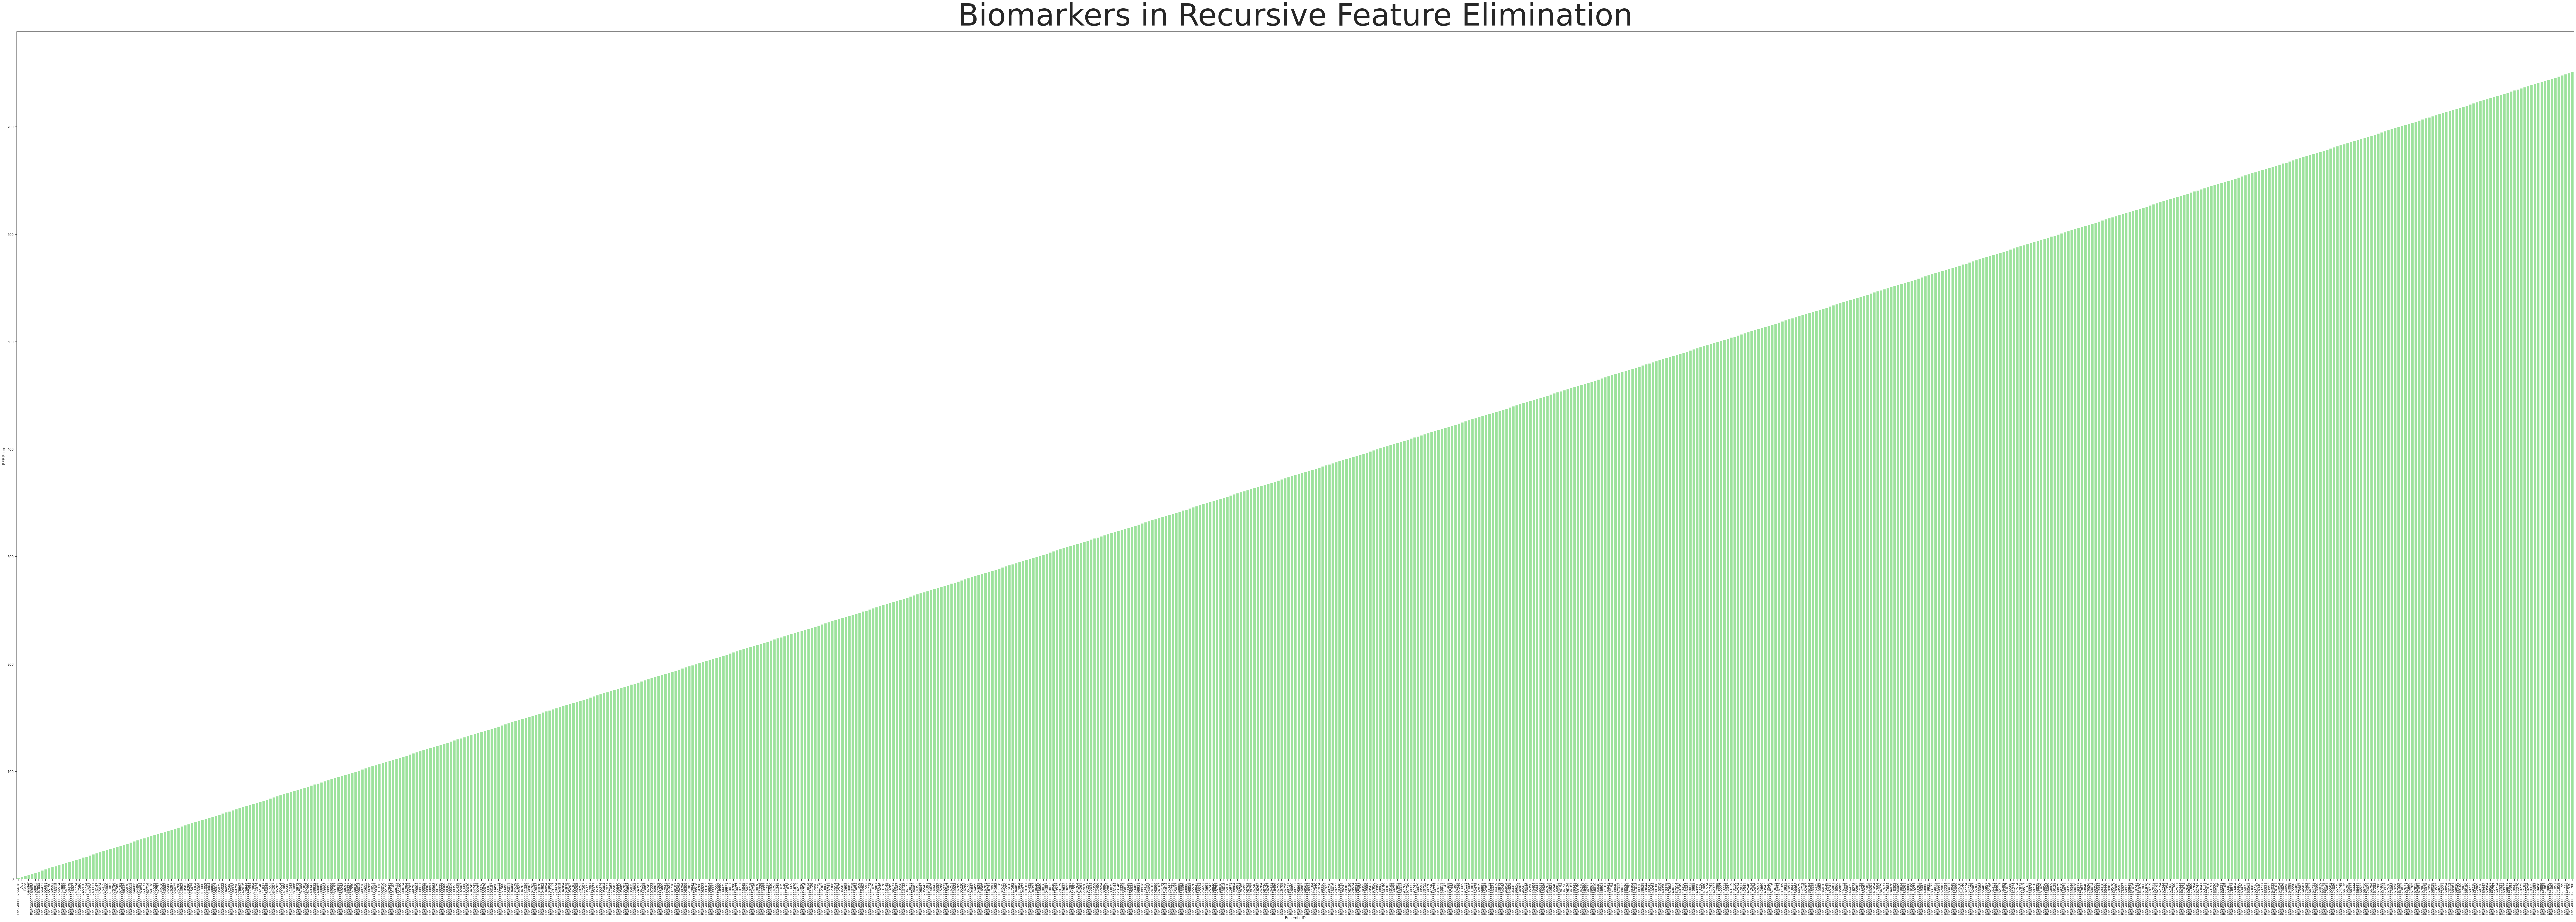

In [ ]:
# Figure). Recursive Feature Elimination
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

rfe_figure = rfe_df_sorted # <--- Figure Information

plt.figure(figsize = (150, 50)) # <--- Figure Size
pearson_plot = sns.barplot(data = rfe_figure, x = "Ensembl ID", y = "RFE Score", color = "#90EE90") # <--- Color
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Biomarkers in Recursive Feature Elimination", fontsize = 100) # <--- Title
plt.show() # <--- Display Figure

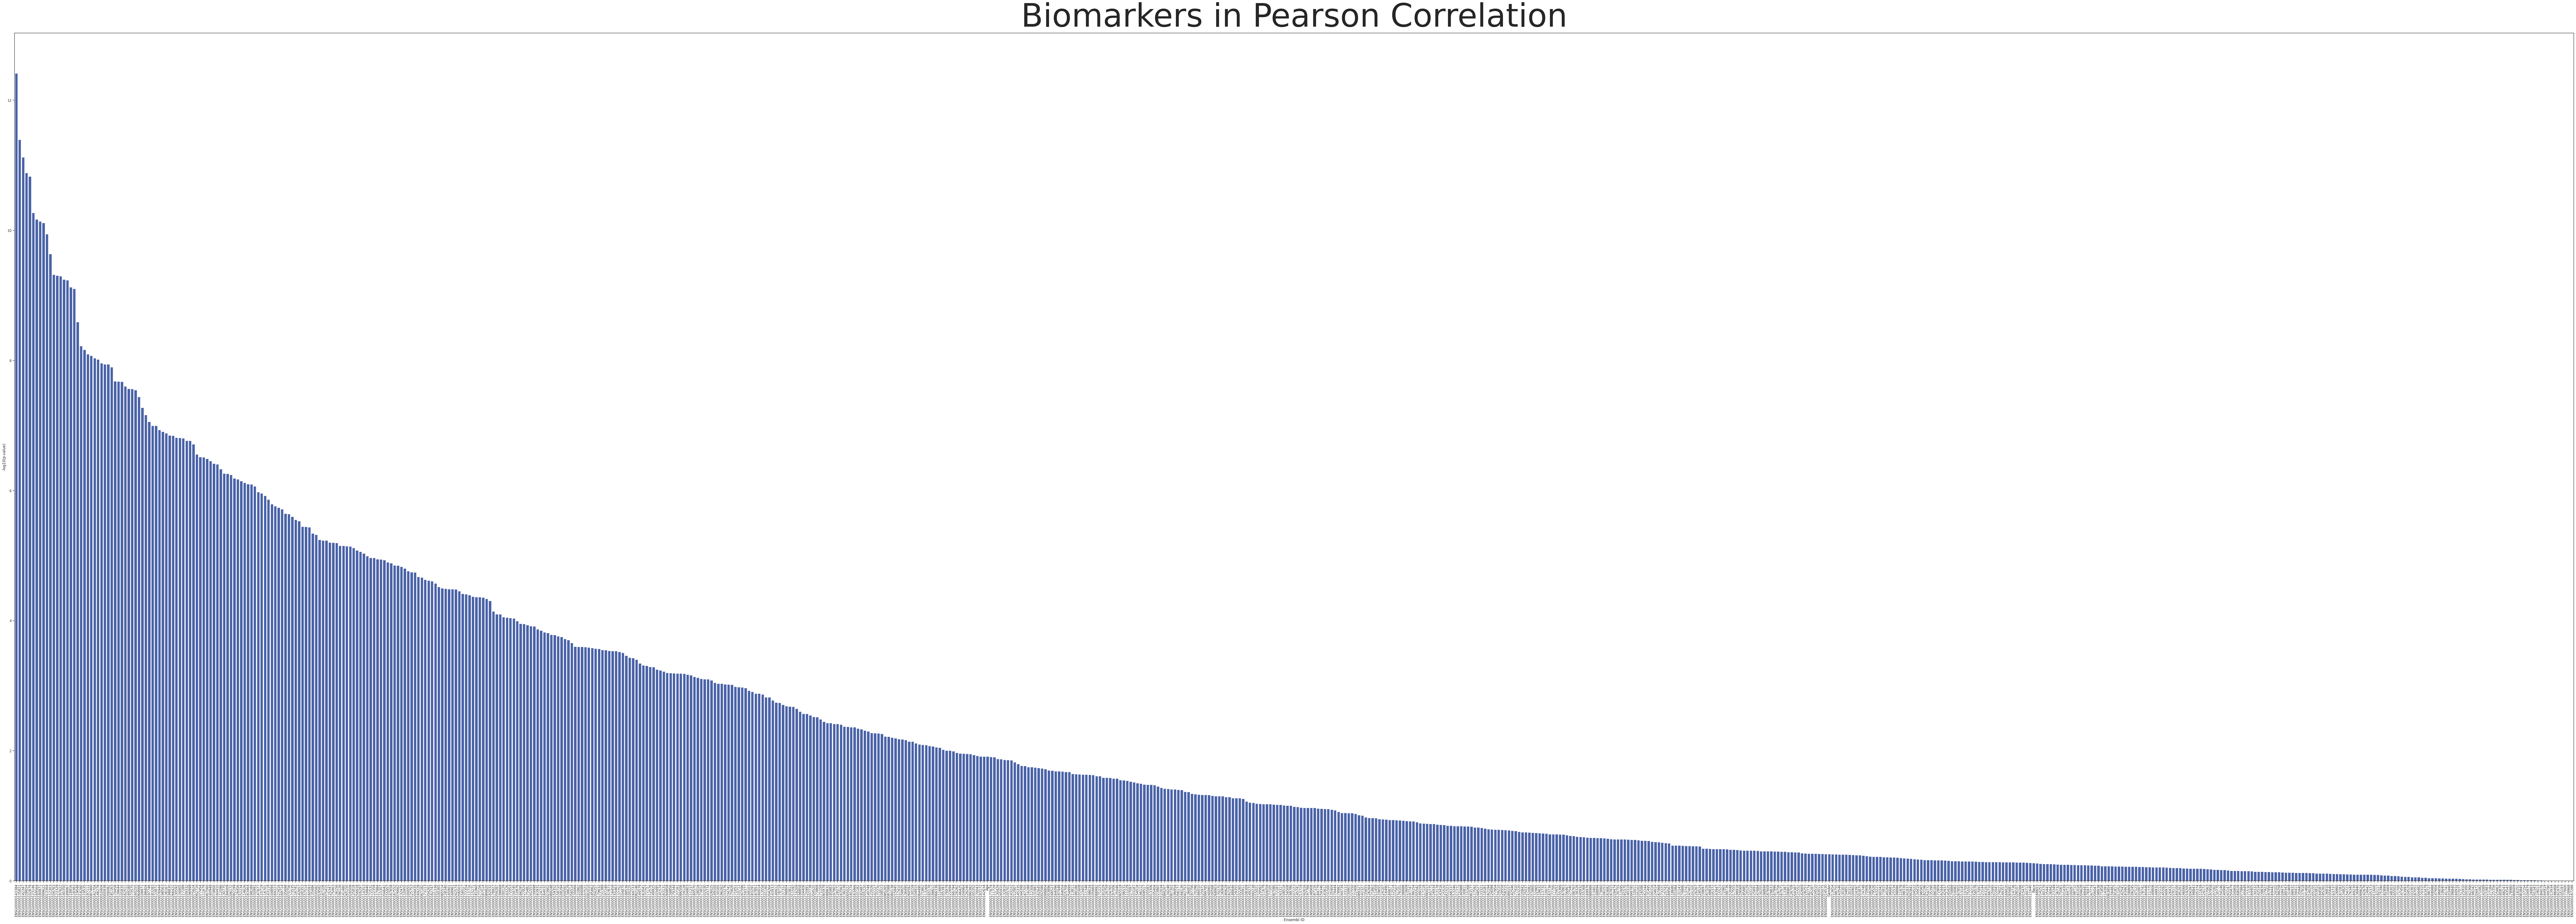

In [ ]:
# Figure). Pearson Correlation
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

pearson_figure = pearson_df_sorted # <--- Figure Information
pearson_figure['-log10(p-value)'] = -np.log10(pearson_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize = (150, 50)) # <--- Figure Size
pearson_plot = sns.barplot(data = pearson_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#395BB8") # <--- Color
plt.xticks(rotation=90) # <--- Vertical Features
plt.title("Biomarkers in Pearson Correlation", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

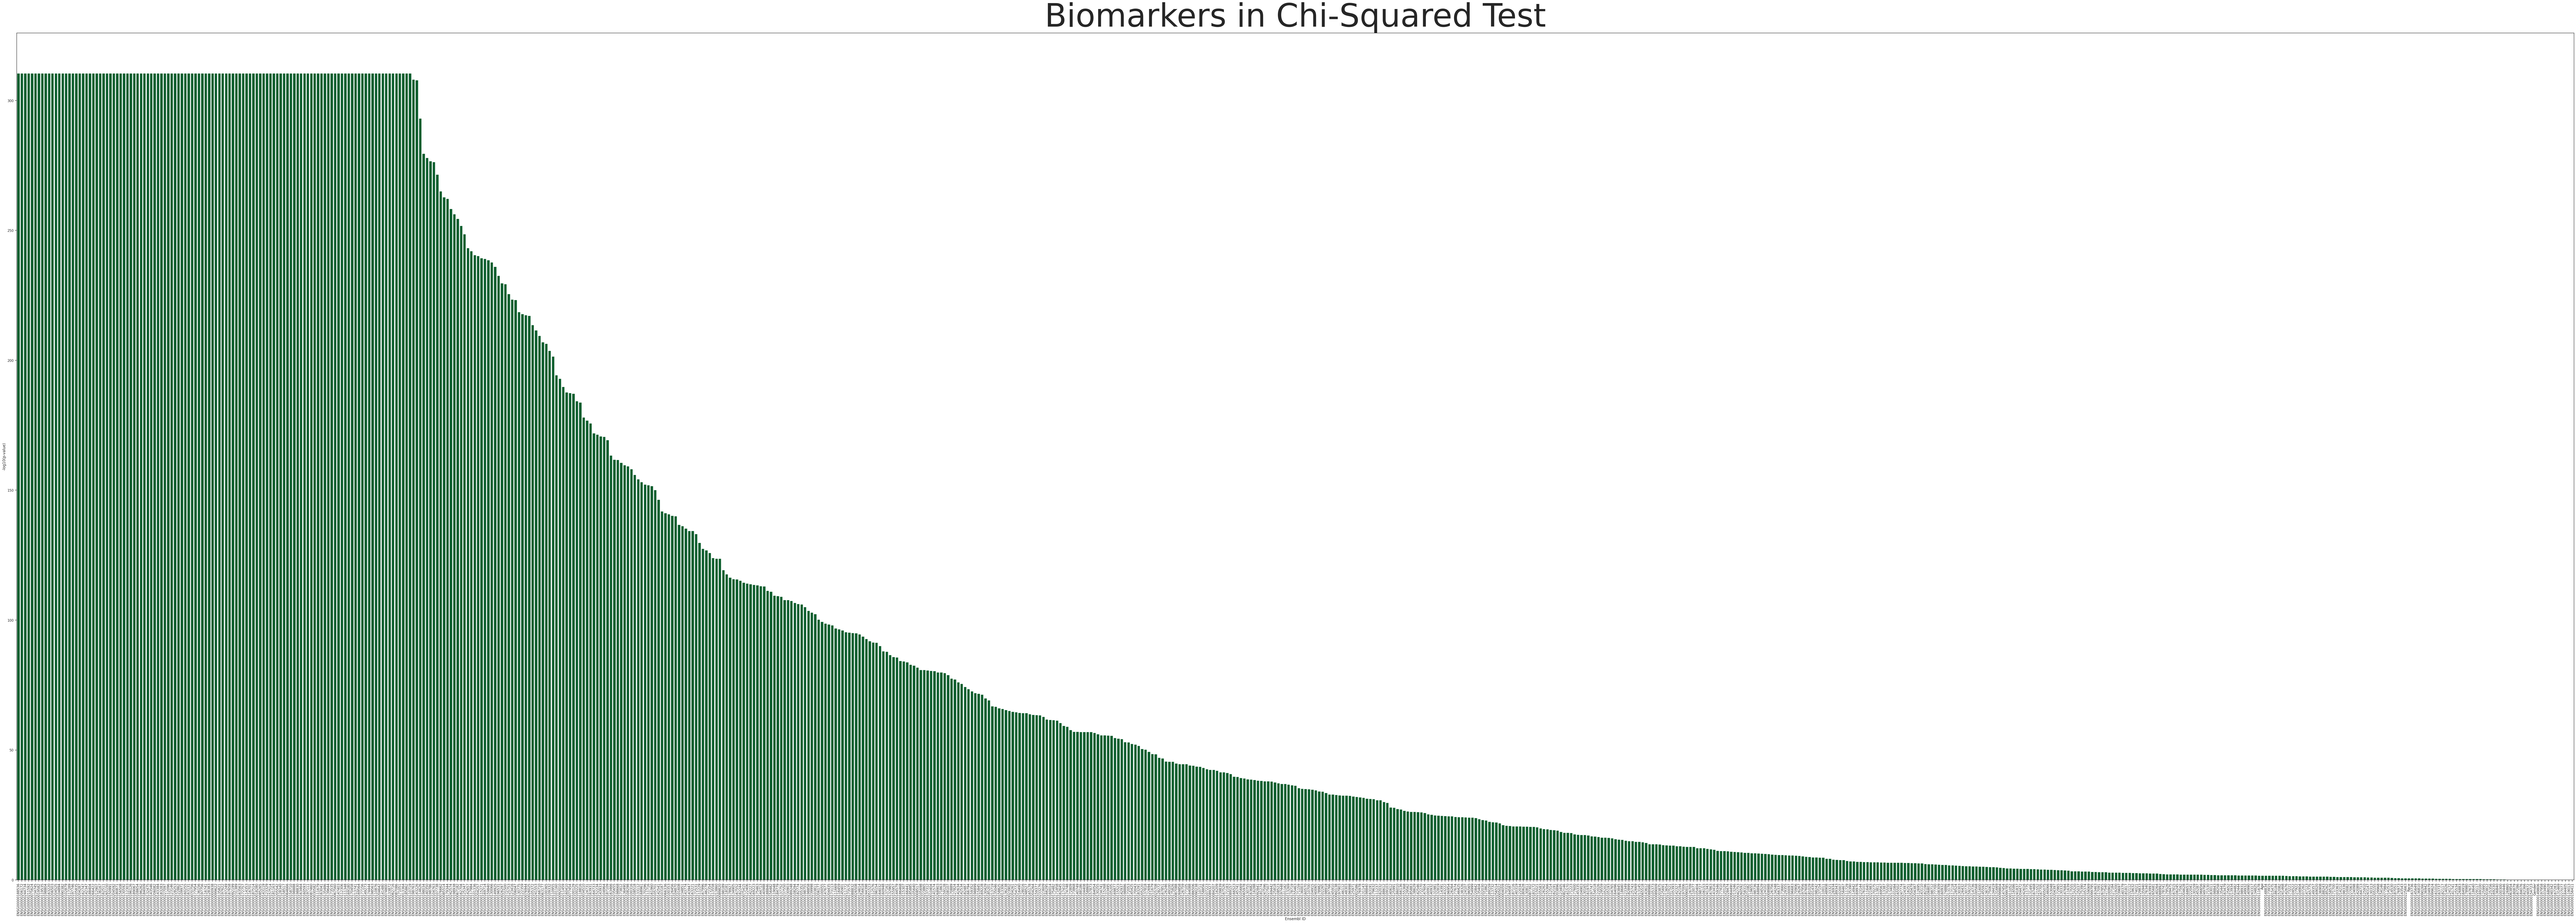

In [ ]:
# Figure). Chi-Squared Test
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

chisq_figure = chisq_df_sorted # <--- Figure Information
minimum_value = chisq_figure.loc[chisq_figure['p-value'] > 0, 'p-value'].min()
chisq_figure.loc[chisq_figure['p-value'] == 0, 'p-value'] = minimum_value # <--- Replace 0 w/ Minimum Value
chisq_figure['-log10(p-value)'] = -np.log10(chisq_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize=(150, 50)) # <--- Figure Size
chisq_plot = sns.barplot(data = chisq_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#006d2c") # <--- Color
plt.xticks(rotation=90) # <--- Vertical Features
plt.title("Biomarkers in Chi-Squared Test", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

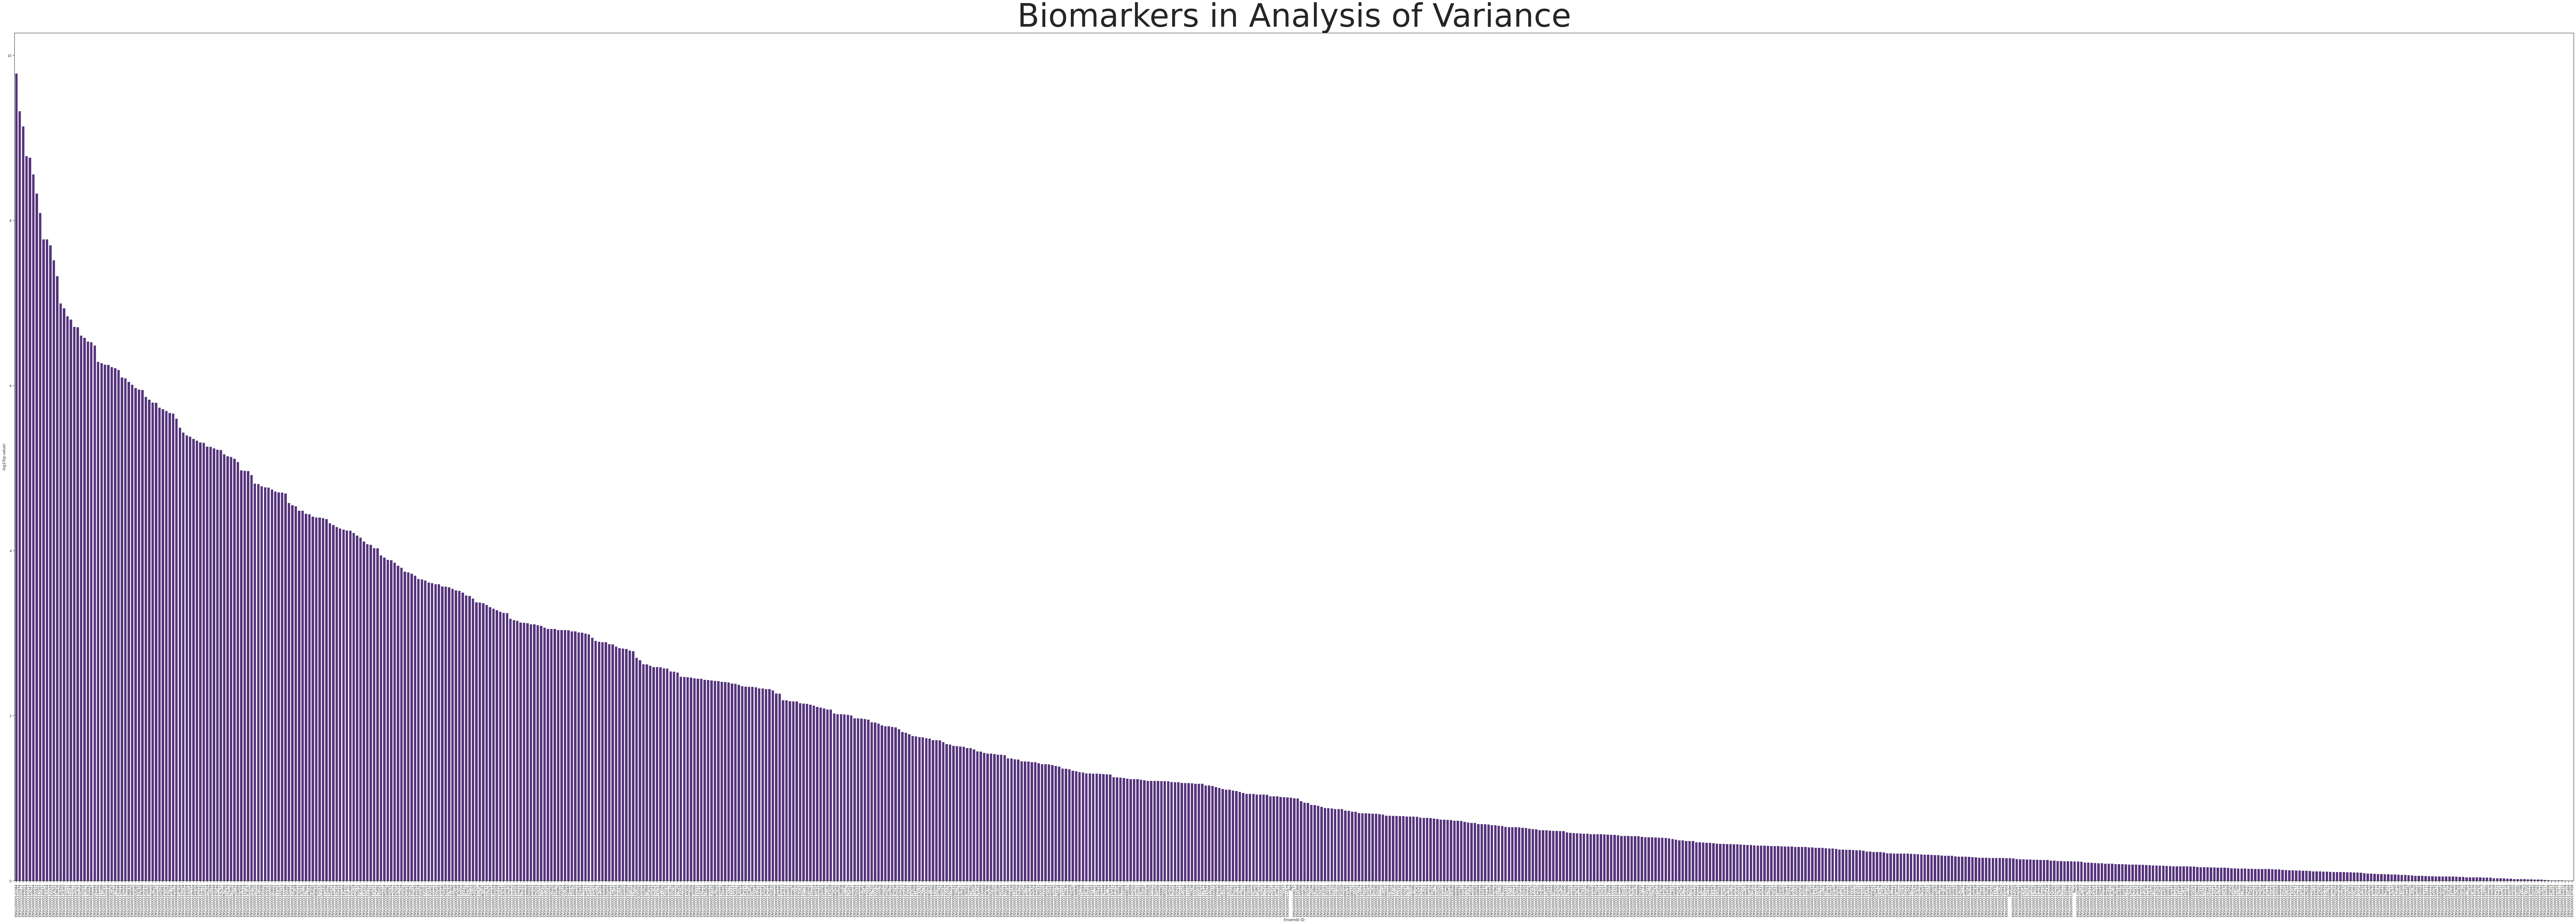

In [ ]:
# Figure). Analysis of Variance
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

anova_figure = anova_df_sorted # <--- Figure Information
anova_figure['-log10(p-value)'] = -np.log10(anova_figure['p-value']) # <--- Normalize p-values

plt.figure(figsize=(150, 50)) # <--- Figure Size
anova_plot = sns.barplot(data = anova_figure, x = "Ensembl ID", y = "-log10(p-value)", color = "#542788")
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Biomarkers in Analysis of Variance", fontsize = 105) # <--- Title
plt.show() # <--- Display Figure

In [22]:
# Figure). Biomarker Table
biomarkers_table = significant_biomarkers_df[['Ensembl ID',
                                              'RFE Score',
                                              'Correlation Coefficient','p-value (Pearson Correlation)',
                                              'Chi-Square Statistic','p-value (Chi-Squared Test)',
                                              'F-Statistic','p-value (ANOVA)',]] # <--- Order Statistics

biomarkers_table.rename(columns={'p-value (ANOVA)': 'p-value (Analysis of Variance)'}, inplace=True) # <--- Rename Statistics

biomarkers_table # <--- Display Figure

#biomarkers_table.to_csv("4A_Feature-Selection-Table_Supported-Biomarkers.csv", index = None)

Ensembl ID  RFE Score  Correlation Coefficient  \
9    ENSG00000013364         53                 0.670849   
19   ENSG00000010404         57                 0.612250   
23   ENSG00000076944         68                 0.576389   
27   ENSG00000000938         64                 0.611739   
29   ENSG00000077454         69                 0.560535   
35   ENSG00000018280         51                 0.620825   
47   ENSG00000064666         35                 0.594722   
56   ENSG00000075624         25                 0.568154   
61   ENSG00000067560         30                 0.559561   
64   ENSG00000062716         39                 0.562216   
69   ENSG00000070756         29                 0.524197   
70   ENSG00000075415         26                 0.505825   
73   ENSG00000030582         44                 0.509974   
75   ENSG00000074800         27                 0.556567   
76   ENSG00000076662         66                 0.487239   
87   ENSG00000019582         50                 0.506274   
104  ENSG00000266422          8                 0.573205   
110  ENSG00000242574         71                 0.468663   
126  ENSG00000256618          1                -0.498578   
134  ENSG00000265150         10                 0.501749   
137  ENSG00000067182         31                 0.478059   
139  ENSG00000026297         46                 0.497705   
141  ENSG00000026508         45                 0.501556   
153  ENSG00000241553         75                 0.437526   
157  ENSG00000023902         49                 0.431554   
160  ENSG00000256514         13                -0.422351   
189  ENSG00000247596         19                 0.378112   
203  ENSG00000269858          5                 0.393315   
223  ENSG00000064490         36                 0.310446   
236  ENSG00000026025         47                 0.385531   
247  ENSG00000005022         61                 0.332979   
249  ENSG00000082146         72                 0.406368   
259  ENSG00000245910         20                 0.290125   
266  ENSG00000042753         42                 0.239748   
283  ENSG00000254999         14                 0.271572   
285  ENSG00000002586         63                 0.276805   
291  ENSG00000066336         32                 0.306523   
300  ENSG00000065978         33                 0.339263   
301  ENSG00000260592         11                 0.314078   
303  ENSG00000060138         40                 0.319363   
307  ENSG00000025708         48                 0.271596   

     p-value (Pearson Correlation)  Chi-Square Statistic  \
9                     1.136979e-10           1478.596447   
19                    1.098521e-08            364.453050   
23                    1.168981e-07            993.923187   
27                    1.138512e-08           3035.833373   
29                    3.046870e-07            855.993460   
35                    5.968765e-09           2545.003799   
47                    3.617854e-08           2196.072199   
56                    1.934780e-07          23617.826150   
61                    3.226232e-07           1846.793395   
64                    2.758971e-07           1531.165598   
69                    2.291080e-06           3259.120339   
70                    5.830227e-06            520.322783   
73                    4.743903e-06           2034.146534   
75                    3.842627e-07           1534.972131   
76                    1.421786e-05           1213.352788   
87                    5.702208e-06          19834.252733   
104                   1.422727e-07           6099.039146   
110                   3.295239e-05           1182.198479   
126                   8.304967e-06            425.057043   
134                   7.121012e-06           5570.193207   
137                   2.167072e-05           1164.492117   
139                   8.661926e-06           1050.494529   
141                   7.188208e-06            431.188959   
153                   1.214456e-04            967

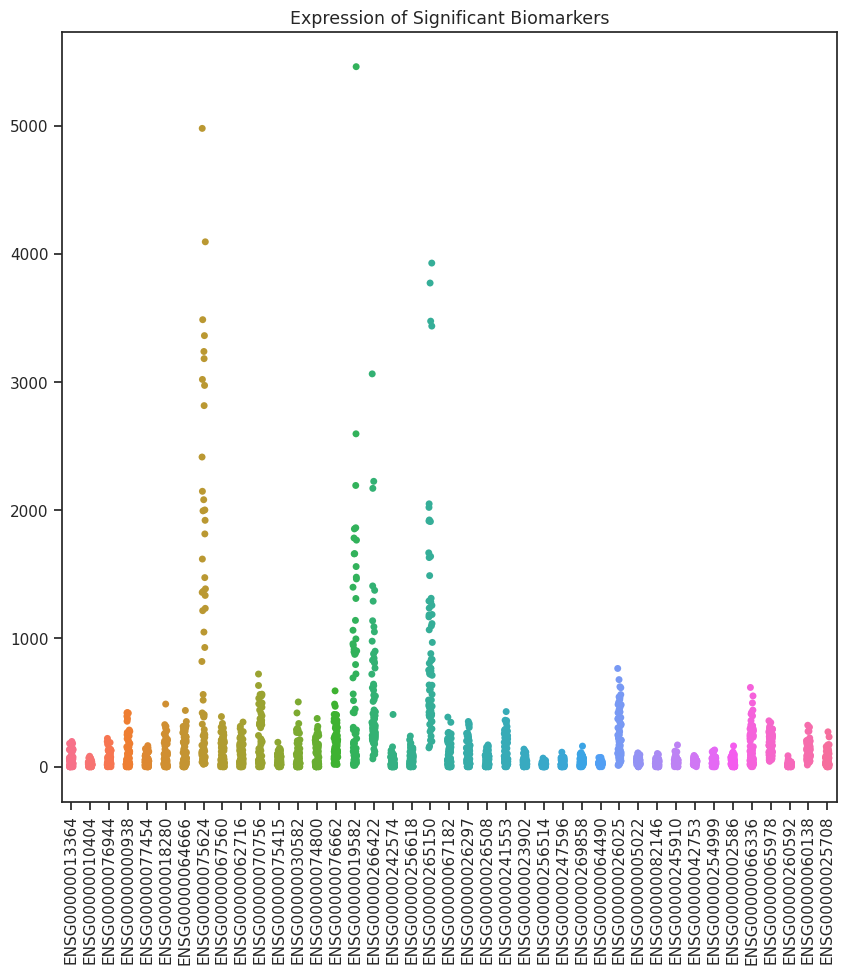

In [ ]:
# Figure). Biomarker Expression
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

plt.figure(figsize = (10,10)) # <--- Figure Size
expression_plot = sns.stripplot(data = df[significant_biomarkers_list])
plt.xticks(rotation = 90) # <--- Vertical Features
plt.title("Expression of Significant Biomarkers", fontsize = 12.5) # <--- Title
plt.show() # <--- Display Figure

<ipython-input-25-5ca05252e20a>:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  correlation_matrix = correlation_df.apply(lambda x: pd.to_numeric(x, errors='ignore')) # <--- Figure Information


<Axes: title={'center': 'Absolute Correlations of Significant Biomarkers'}>

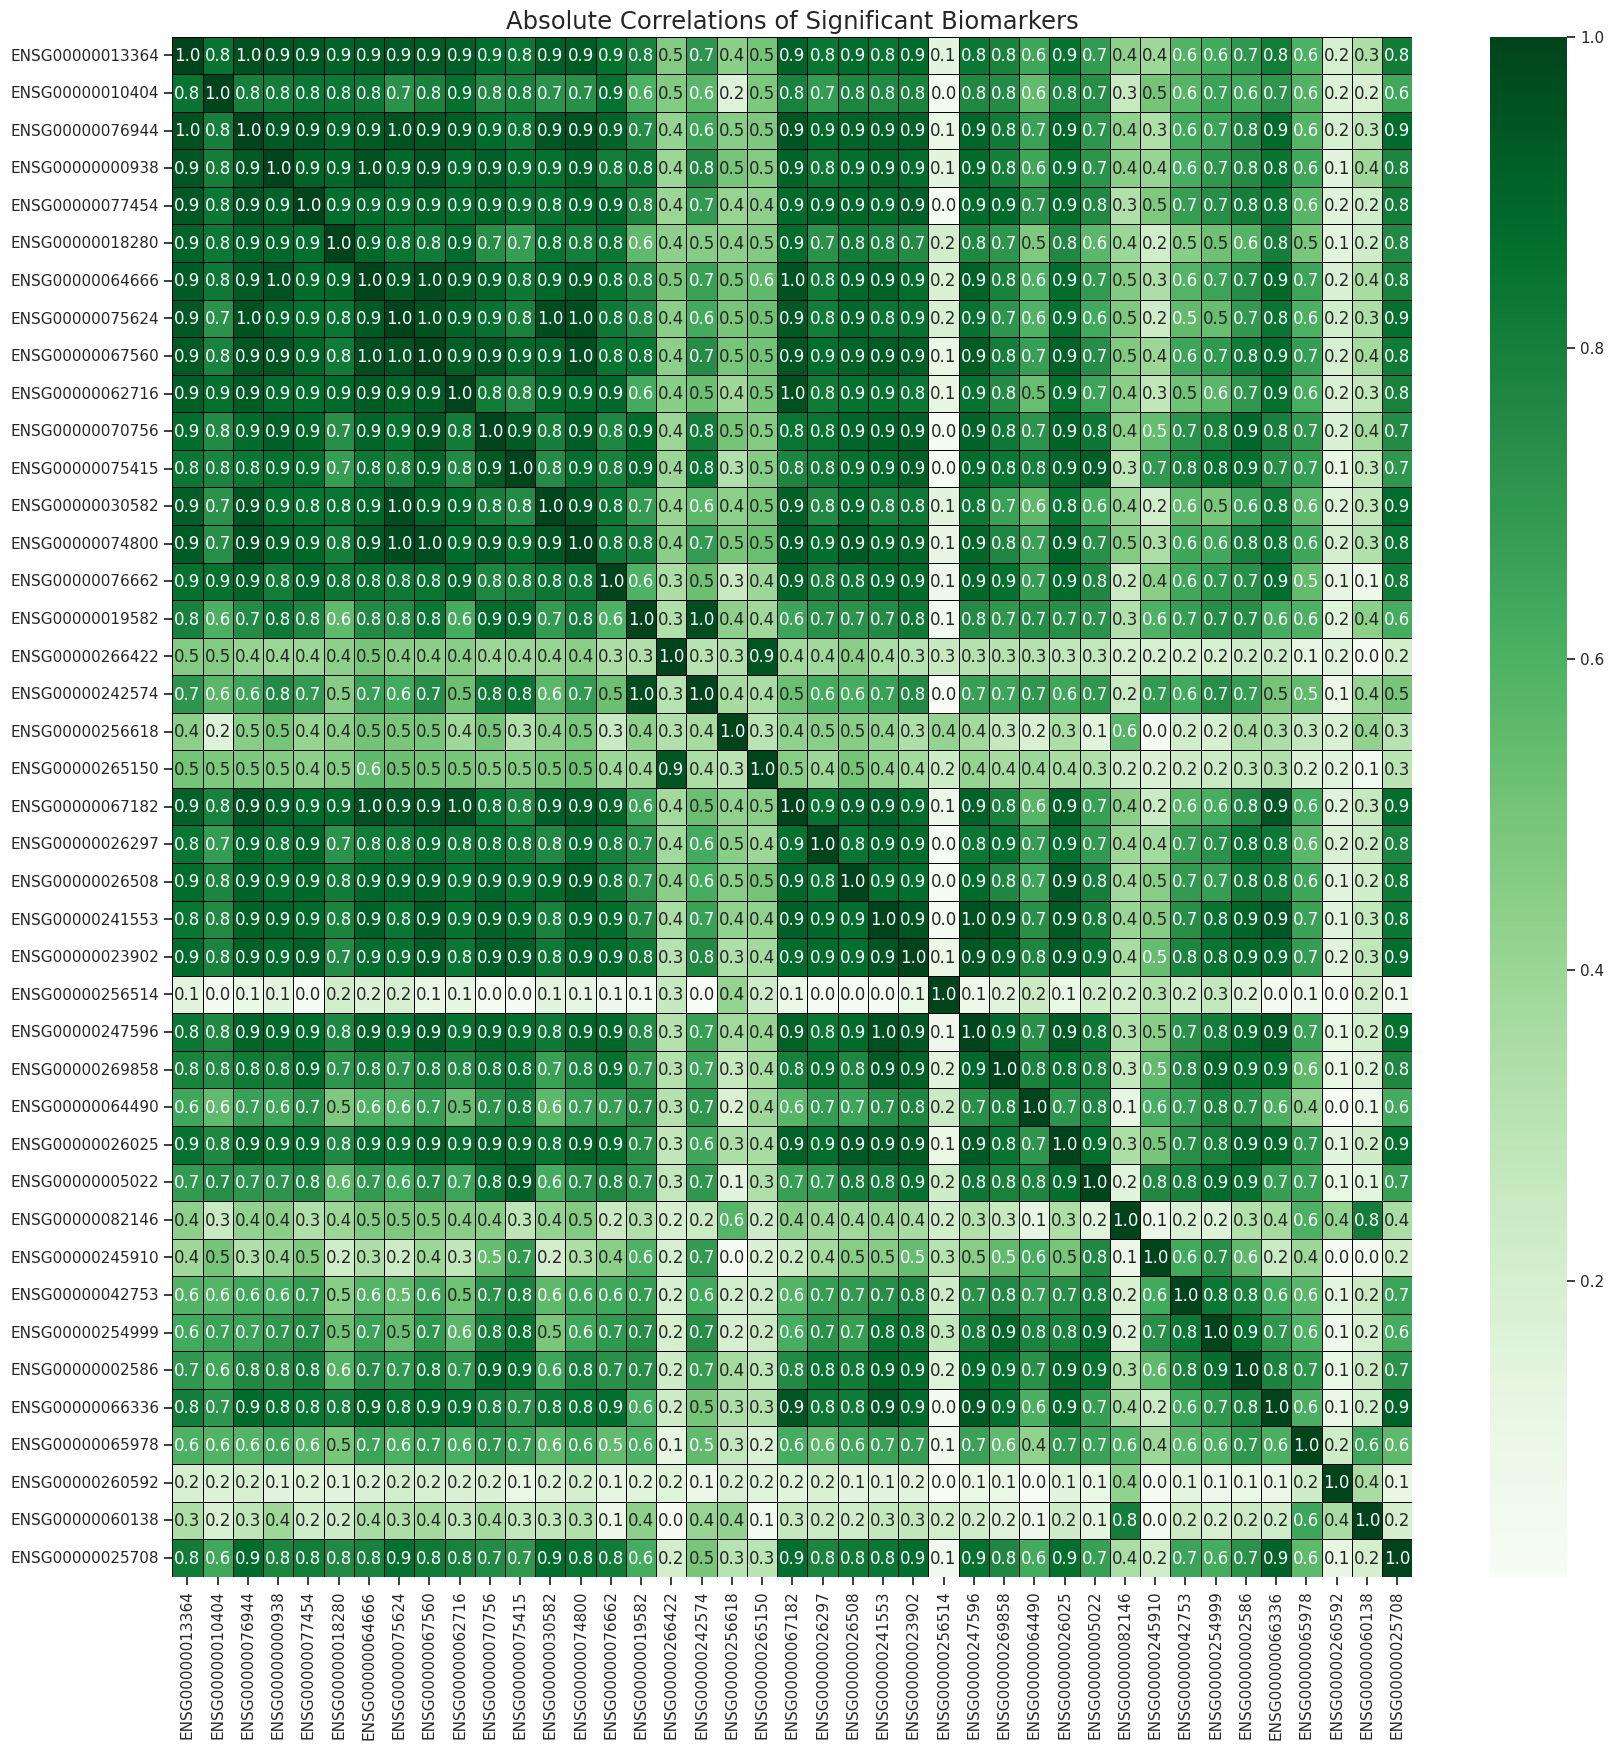

In [ ]:
# Figure). Biomarker Correlations
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

correlation_df = df[significant_biomarkers_list]
correlation_matrix = correlation_df.apply(lambda x: pd.to_numeric(x, errors='ignore')) # <--- Figure Information

f, ax = plt.subplots(figsize=(20, 20))  # <--- Figure Size
plt.title("Absolute Correlations of Significant Biomarkers", fontsize = 17.5)  # <--- Title
sns.heatmap(correlation_matrix.corr().abs(),
            annot=True, linewidths=.5, fmt='.1f', ax=ax, linecolor='black', cmap='Greens')  # <--- Display Figure

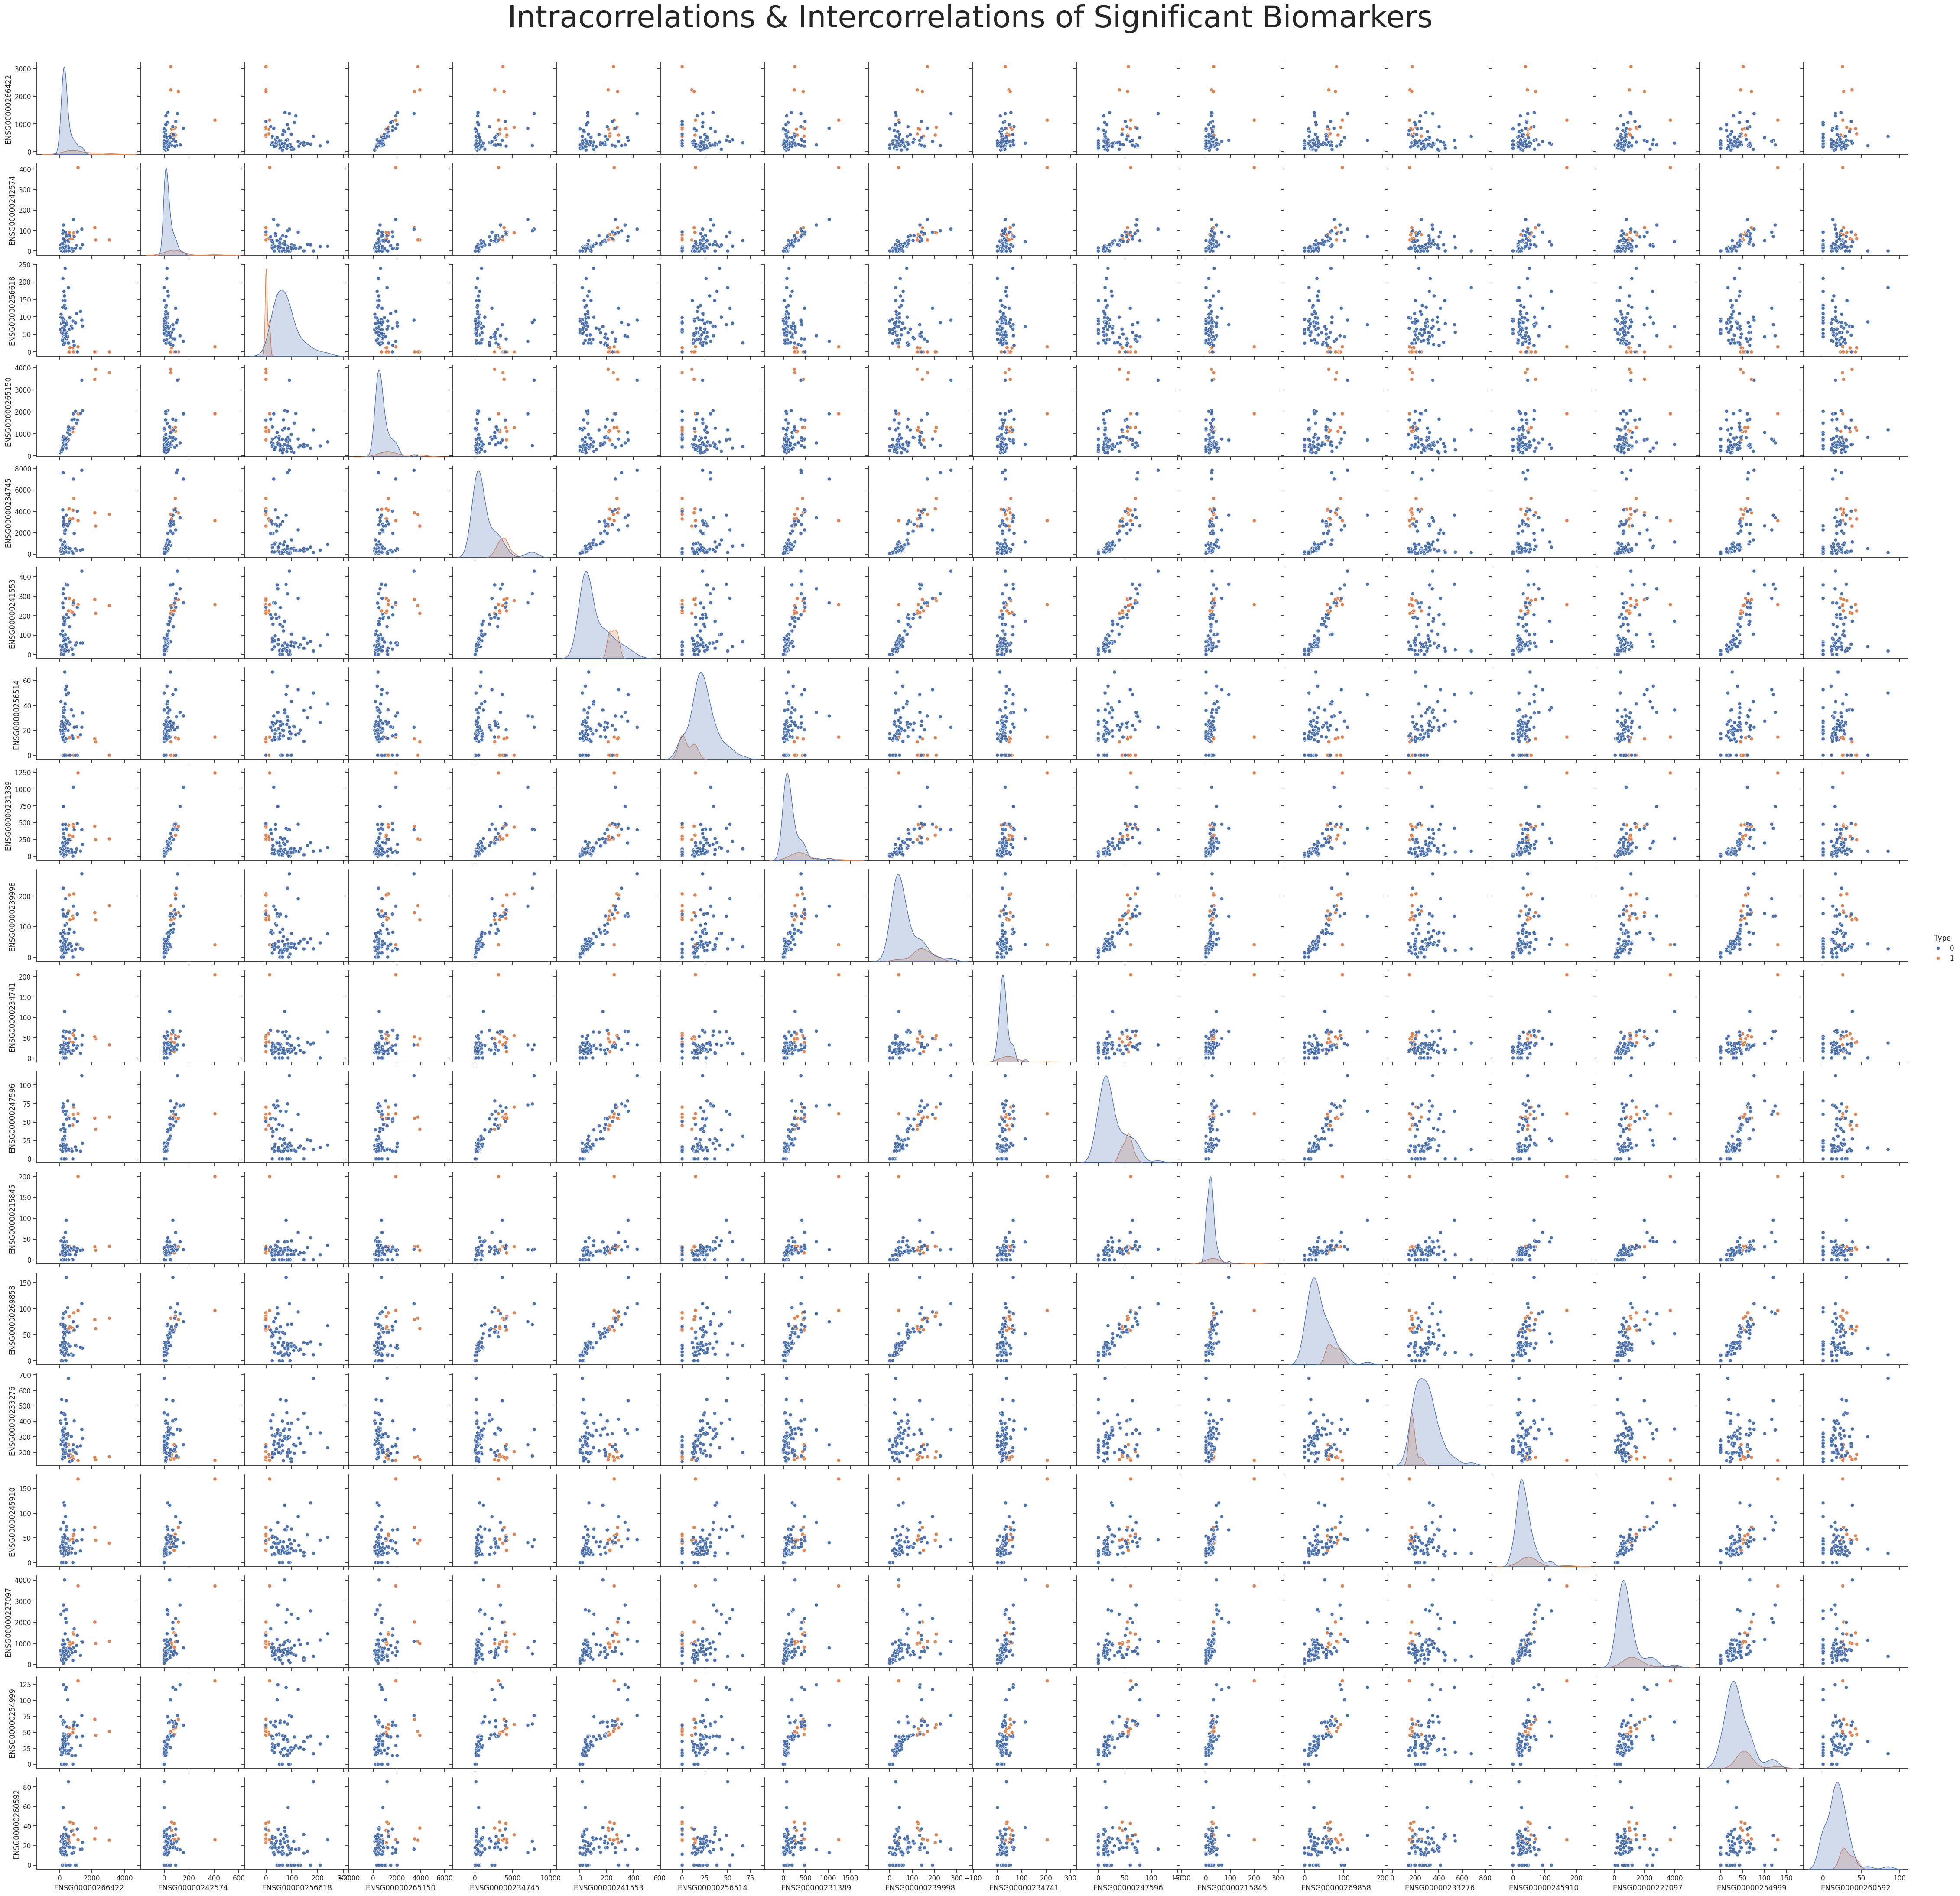

In [ ]:
# Figure). Biomarker Pairwise Relationships
sns.set_style("whitegrid")
sns.set_style("ticks") # <--- Seaborn Settings

pairwise_df = df[significant_biomarkers_list]
pairwise_df = pairwise_df.assign(Type = df['Type'])
pairwise = sns.pairplot(pairwise_df, hue = "Type") # <--- Figure Information

figure = pairwise.fig
figure.subplots_adjust(top = 0.95, wspace = 0) # <--- Figure Size
t = figure.suptitle('Intracorrelations & Intercorrelations of Significant Biomarkers', fontsize = 50) # <--- Display Figure

Model Accuracy: 0.9090909090909091


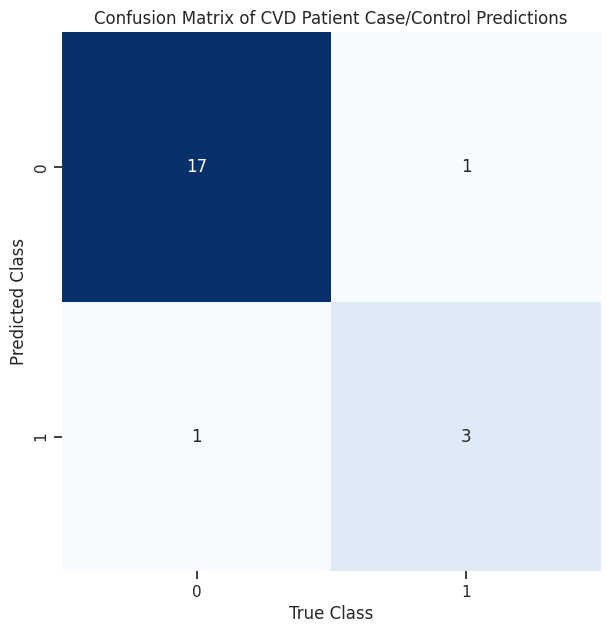

In [ ]:
# Figure). Confusion Matrix
figure_size = (7, 7)
figure = plt.figure(figsize = figure_size) # <--- Figure Size

cm = confusion_matrix(y_test, y_predict) # <--- Generate Confusion Matrix
ax = sns.heatmap(cm.T, square = True, annot = True, fmt = 'd', cbar = False, cmap='Blues')

figure_title = 'Confusion Matrix of CVD Patient Case/Control Predictions'
plt.title(figure_title)  # <--- Figure Title
x_label = 'True Class'
plt.xlabel(x_label) # <--- Horizontal Axis Title
y_label = 'Predicted Class'
plt.ylabel(y_label) # <--- Vertical Axis Title

print(f'Model Accuracy: {soft_voting_classifier_accuracy}')
plt.show() # <--- Display Figure

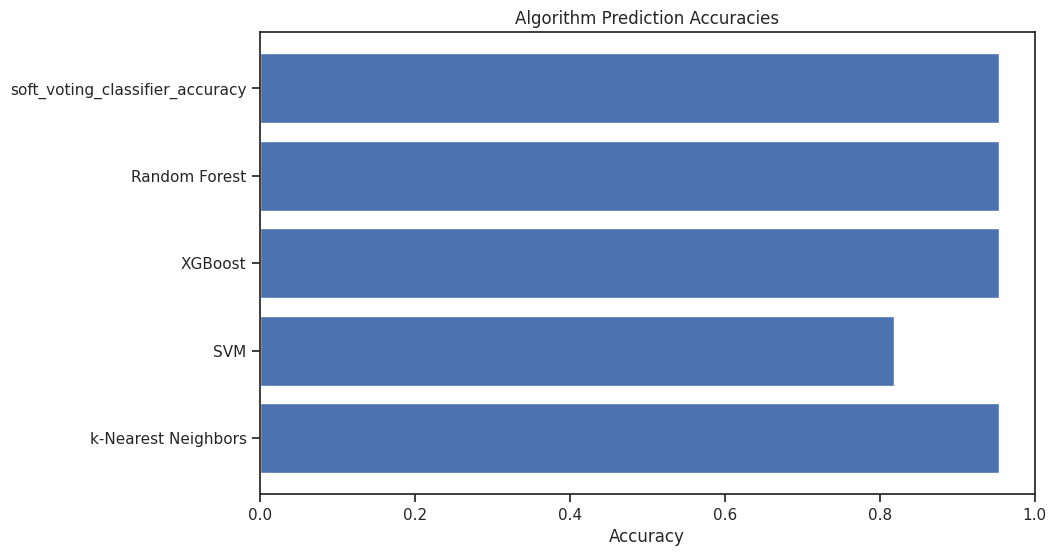

In [25]:
# Figure). Algorithm Accuracies

def plot_algorithm_accuracies(accuracies, algorithm_names, title = 'Algorithm Prediction Accuracies'):
    plt.figure(figsize=(10, 6))
    plt.barh(algorithm_names, accuracies, align = 'center')
    plt.xlabel('Accuracy')
    plt.xlim(0, 1)
    plt.title(title)
    plt.show()

accuracies = [knn_accuracy, xgb_accuracy, svmc_accuracy, rf_accuracy,soft_voting_classifier_accuracy] # <--- Accuracy Variables
algorithms = ['k-Nearest Neighbors', 'SVM', 'XGBoost', 'Random Forest',"soft_voting_classifier_accuracy"] # <--- Algorithms

plot_algorithm_accuracies(accuracies, algorithms) # <--- Display Figure

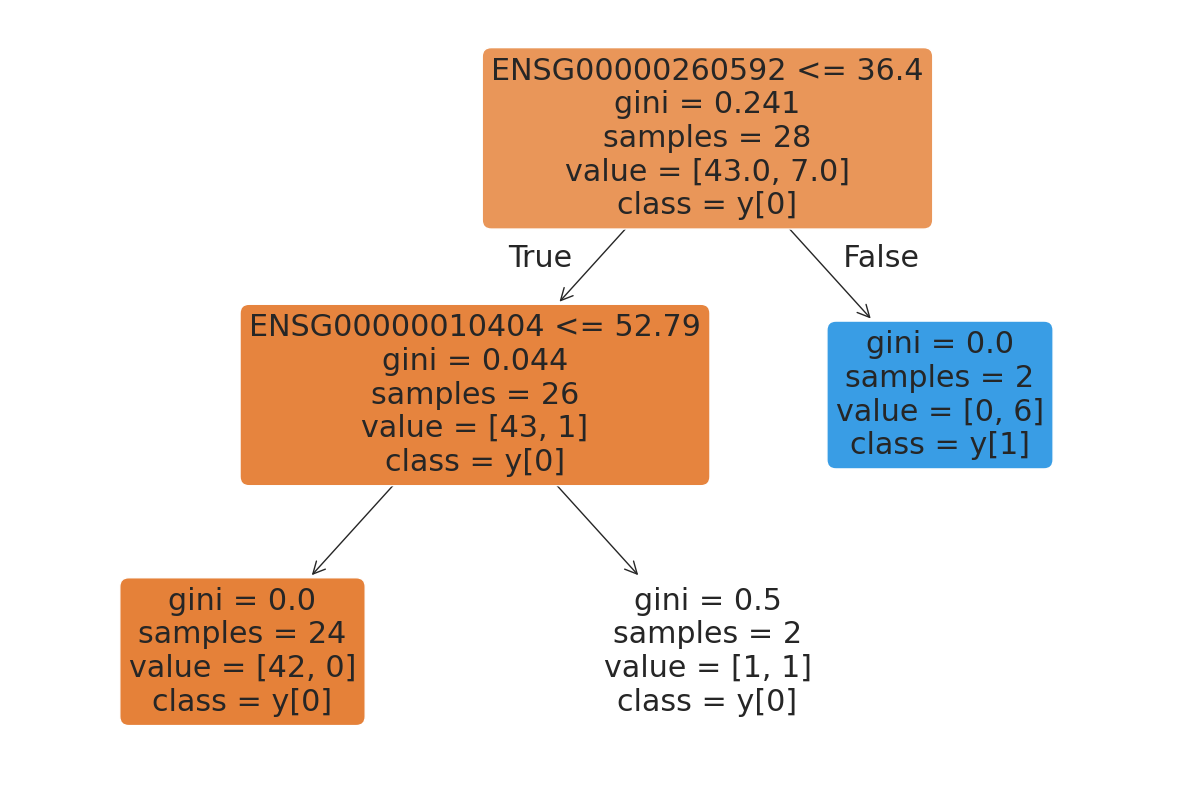

In [28]:
# Figure). Random Forest
best_tree_index = np.argmax([tree.tree_.max_depth for tree in rf_best.estimators_])
best_tree = rf_best.estimators_[best_tree_index]

plt.figure(figsize=(15, 10)) # <--- Figure Size
plot_tree(best_tree, filled=True, feature_names=x_train.columns, class_names=True, rounded=True) # <--- Best Tree
plt.show() # <--- Display Figure

In [ ]:
# prompt: plot a ROC considering all the models from above
# what do this means rf_best, svmc_best, xgb_best, knn_best, soft_voting_classifier

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_test and the probability predictions for each model
# Example: y_probs_rf, y_probs_svmc, etc.

plt.figure(figsize=(10, 8))

# Function to plot ROC curve for a single model
def plot_roc_curve(y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')


# Plot ROC curves for all models
plot_roc_curve(rf_best_random.predict_proba(x_test)[:, 1], 'rf_best_random') # Use rf_best_random instead of rf_best
plot_roc_curve(svmc_best.predict_proba(x_test)[:, 1], 'svmc_best')
plot_roc_curve(xgb_best.predict_proba(x_test)[:, 1], 'xgb_best')
plot_roc_curve(knn_best.predict_proba(x_test)[:, 1], 'knn_best')
plot_roc_curve(soft_voting_classifier.predict_proba(x_test)[:, 1], 'soft_voting_classifier')


plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc='lower right')
plt.show()

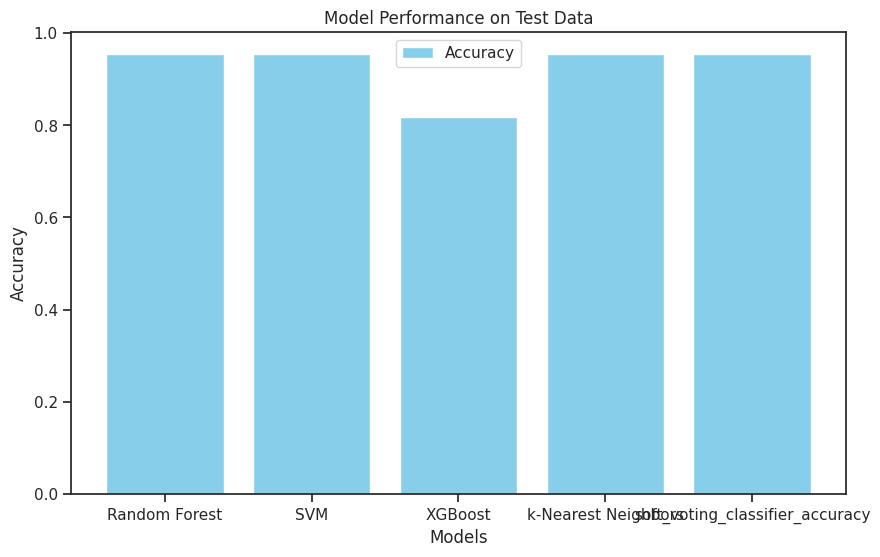

ValueError: 'yerr' (shape: (4,)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (5,))

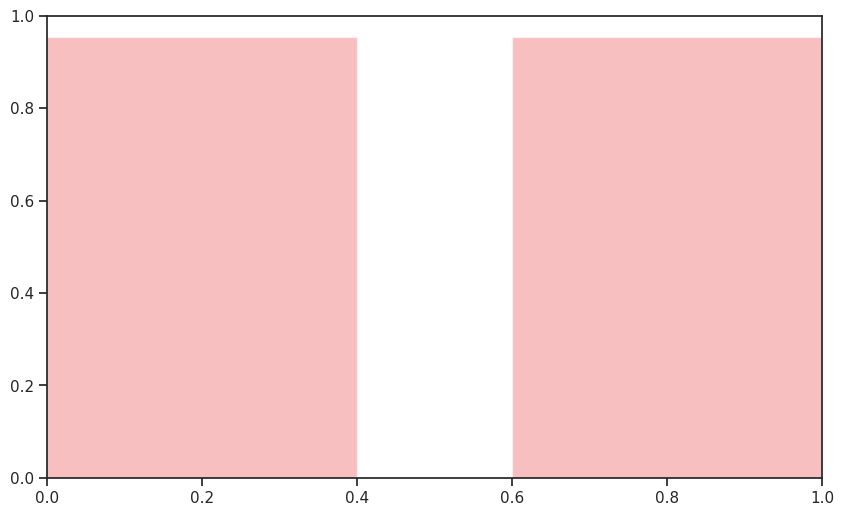

In [27]:
# prompt: generate the graph for comparing the models (used in this notebook) performance and their standard deviation and variance using the test data

import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the following variables storing accuracy, standard deviation, and variance for each model
# Replace these with your actual values
model_names = ['Random Forest', 'SVM', 'XGBoost', 'k-Nearest Neighbors',"soft_voting_classifier_accuracy"]
accuracies = [rf_accuracy, svmc_accuracy, xgb_accuracy, knn_accuracy,soft_voting_classifier_accuracy]
standard_deviations = [0.05, 0.03, 0.04, 0.06]  # Example standard deviations
variances = [0.0025, 0.0009, 0.0016, 0.0036]  # Example variances

# Create a bar chart for accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue', label='Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance on Test Data')
plt.legend()
plt.show()

# Create an error bar chart for standard deviation and variance
x_pos = np.arange(len(model_names))
plt.figure(figsize=(10, 6))
plt.bar(x_pos, accuracies, yerr=standard_deviations, align='center', alpha=0.5, ecolor='black', capsize=10, color='lightcoral')
plt.xticks(x_pos, model_names)
plt.xlabel('Models')
plt.ylabel('Accuracy with Standard Deviation')
plt.title('Model Performance and Standard Deviation')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x_pos, accuracies, yerr=np.sqrt(variances), align='center', alpha=0.5, ecolor='black', capsize=10, color='lightgreen')
plt.xticks(x_pos, model_names)
plt.xlabel('Models')
plt.ylabel('Accuracy with Variance')
plt.title('Model Performance and Variance')
plt.show()